# Initial Setup
This section imports necessary libraries and defines constants used throughout the tasks. We assume a 15x15 grid where a drone navigates to find a rescue goal, managing fuel and lives while avoiding hazards.

In [1]:
import random
import math
import time
import copy
import numpy as np
import heapq
import matplotlib.pyplot as plt

# Constants
GRID_SIZE = 15
MAX_STEPS = 30
PERCEPTION_RADIUS = 2
INITIAL_FUEL = 10
INITIAL_LIVES = 3

# Terrain types
TERRAIN_TYPES = ['.', 'M', 'N', 'E', 'S', 'G']  # .: clear, M: mountain, N: no-fly, E: energy, S: storm, G: goal

# Task 2: State-Space Modeling
Here, we model the drone's navigation problem as a state-space search. We define:
- **State**: The drone's current situation (position, fuel, lives, etc.).
- **Successor Function**: Possible next states based on legal moves.
- **Transition Model**: How the state changes with an action.
- **Cost Function**: Cumulative cost, balancing steps and lives lost.
- **Goal Test**: Whether the drone has reached the goal with lives remaining.

For simplicity, we assume a static environment and a known goal position initially, though in practice, the goal is only visible within a perception radius of 2.

## Environment Class
The `Environment` class represents the true terrain, a 15x15 grid with a randomly placed goal and mountains (20% of cells). Other terrain types (no-fly zones, energy stations, storms) can be added similarly but are simplified here for focus on state-space modeling.

In [2]:
class Environment:
    def __init__(self, goal_x, goal_y):
        if not (0 <= goal_x < GRID_SIZE and 0 <= goal_y < GRID_SIZE):
            raise ValueError("Goal coordinates must be within 0 to 14")
        self.grid = np.full((GRID_SIZE, GRID_SIZE), '.', dtype=str)
        self.goal = (goal_x, goal_y)
        self.grid[self.goal] = 'G'
        # Place mountains in 20% of cells, excluding goal
        num_mountains = int(0.2 * GRID_SIZE * GRID_SIZE)
        mountain_positions = random.sample(
            [(i, j) for i in range(GRID_SIZE) for j in range(GRID_SIZE) if (i, j) != self.goal],
            num_mountains
        )
        for pos in mountain_positions:
            self.grid[pos] = 'M'

    def get_terrain(self, x, y):
        return self.grid[x, y]

## Drone State Class
The `DroneState` class defines the drone's state, including position, fuel, lives, path cost, known hazards, visible map, and time step.

In [3]:
class DroneState:
    def __init__(self, x, y, fuel, lives, path_cost, known_no_fly_zones, known_storm_map, visible_map, time_step, path=None):
        self.x = x
        self.y = y
        self.fuel = fuel
        self.lives = lives
        self.path_cost = path_cost
        self.known_no_fly_zones = known_no_fly_zones
        self.known_storm_map = known_storm_map
        self.visible_map = visible_map
        self.time_step = time_step
        self.path = path if path is not None else [(x, y)]  # Track path as list of (x, y)

    def __lt__(self, other):
        """Define less-than comparison for priority queue tie-breaking."""
        return (self.x, self.y, self.fuel, self.lives, self.time_step) < \
               (other.x, other.y, other.fuel, other.lives, other.time_step)

## Visible Map Function
The `get_visible_map` function returns a dictionary of terrain types within the drone's perception radius (2 cells), updating the drone's knowledge of the environment.

In [4]:
def get_visible_map(x, y, env):
    visible = {}
    for i in range(max(0, x - PERCEPTION_RADIUS), min(GRID_SIZE, x + PERCEPTION_RADIUS + 1)):
        for j in range(max(0, y - PERCEPTION_RADIUS), min(GRID_SIZE, y + PERCEPTION_RADIUS + 1)):
            if max(abs(i - x), abs(j - y)) <= PERCEPTION_RADIUS:
                visible[(i, j)] = env.get_terrain(i, j)
    return visible



## Transition Model
The `transition_model` function updates the state based on the action (new position). It handles fuel consumption, life loss from hazards, refueling at energy stations, and updates known hazards and the visible map.

In [5]:
def transition_model(state, action, env):
    nx, ny = action
    new_fuel = state.fuel - 1
    terrain = env.get_terrain(nx, ny)
    if terrain == 'E':
        new_fuel = INITIAL_FUEL
    new_lives = state.lives
    if terrain in {'M', 'S'}:
        new_lives -= 1
    if new_fuel < 0:
        new_lives -= 1
    new_path_cost = state.path_cost + 1 + 10 * max(0, state.lives - new_lives)
    new_time_step = state.time_step + 1
    new_visible_map = get_visible_map(nx, ny, env)
    new_known_no_fly_zones = state.known_no_fly_zones.union(
        {(i, j) for (i, j), t in new_visible_map.items() if t == 'N'}
    )
    new_known_storm_map = state.known_storm_map.union(
        {(i, j) for (i, j), t in new_visible_map.items() if t == 'S'}
    )
    # Append new position to path
    new_path = state.path + [(nx, ny)]
    new_state = DroneState(
        nx, ny, new_fuel, new_lives, new_path_cost,
        new_known_no_fly_zones, new_known_storm_map, new_visible_map, new_time_step, new_path
    )
    return new_state

## Successor Function
The `get_successors` function generates all possible next states by considering eight-directional moves, ensuring they are within bounds, not known no-fly zones, and the drone has lives and steps remaining.

In [6]:
def get_successors(state, env):
    successors = []
    directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    for dx, dy in directions:
        nx, ny = state.x + dx, state.y + dy
        if (0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE and
            (nx, ny) not in state.known_no_fly_zones):
            new_state = transition_model(state, (nx, ny), env)
            if new_state.lives > 0 and new_state.time_step <= MAX_STEPS:
                successors.append(new_state)
    return successors


## Goal Test
The goal test is implicitly handled in the A* search by checking if the current position matches the goal with lives remaining. For clarity, we define it explicitly here.

In [7]:
def is_goal_state(state, goal):
    return (state.x, state.y) == goal and state.lives > 0

# Task 3: Heuristic Design & Evaluation
We design five unique heuristic functions for A* search and evaluate their performance. Each heuristic estimates the cost from the current state to the goal, and we analyze their admissibility and consistency. We then implement A* to compare them based on path cost, nodes expanded, and execution time.

**Assumption**: The goal position is known for heuristic computation, though in the problem, it's only visible within radius 2. In practice, this would require an online search approach, but we simplify here for demonstration.

## Heuristic Functions
We define five heuristics:
1. **h1**: Chebyshev distance to the goal (admissible, consistent).
2. **h2**: Distance with refueling adjustment (admissible, not consistent).
3. **h3**: Obstacle-adjusted distance (inadmissible, inconsistent).
4. **h4**: Fuel-aware distance (admissible, not consistent).
5. **h5**: Minimal heuristic (zero, admissible, consistent, but inefficient).

In [8]:
def h1(state, goal):
    """Chebyshev distance to goal"""
    return max(abs(state.x - goal[0]), abs(state.y - goal[1]))

def h2(state, goal):
    """Distance with refueling adjustment"""
    d = h1(state, goal)
    return d + math.floor(d / 10)

def h3(state, goal):
    """Obstacle-adjusted distance"""
    d = h1(state, goal)
    m = sum(1 for v in state.visible_map.values() if v == 'M')
    v = len(state.visible_map)
    return d * (1 + m / v if v > 0 else 1)

def h4(state, goal):
    """Fuel-aware distance"""
    d = h1(state, goal)
    if state.fuel < 5:
        return d + 2
    return d

def h5(state, goal):
    """Minimal heuristic"""
    return 0

## A* Search
The `astar` function implements the A* algorithm using a priority queue. It tracks path cost (g(n)), heuristic cost (h(n)), and total cost (f(n) = g(n) + h(n)), returning the path cost, nodes expanded, and execution time when the goal is reached.

In [9]:
def astar(initial_state, goal, heuristic, env):
    frontier = []
    heapq.heappush(frontier, (0, initial_state))
    explored = set()
    nodes_expanded = 0
    start_time = time.time()
    while frontier:
        _, current = heapq.heappop(frontier)
        nodes_expanded += 1
        if is_goal_state(current, goal):
            end_time = time.time()
            return current.path_cost, nodes_expanded, end_time - start_time, current.path
        explored.add((current.x, current.y, current.fuel, current.lives, current.time_step))
        for successor in get_successors(current, env):
            if (successor.x, successor.y, successor.fuel, successor.lives, successor.time_step) not in explored:
                g = successor.path_cost
                h = heuristic(successor, goal)
                f = g + h
                heapq.heappush(frontier, (f, successor))
    end_time = time.time()
    exec_time = end_time - start_time
    return path_cost, nodes_expanded, exec_time, path

## Running and Comparing Heuristics
We set up the initial state and environment, then run A* with each heuristic to compare their performance.

Heuristic Comparison Results:
h1: Path Cost = 5, Nodes Expanded = 16, Time = 0.0160 seconds
h2: Path Cost = 5, Nodes Expanded = 16, Time = 0.0048 seconds
h3: Path Cost = 5, Nodes Expanded = 7, Time = 0.0000 seconds
h4: Path Cost = 5, Nodes Expanded = 16, Time = 0.0000 seconds
h5: Path Cost = 5, Nodes Expanded = 4522, Time = 1.1643 seconds


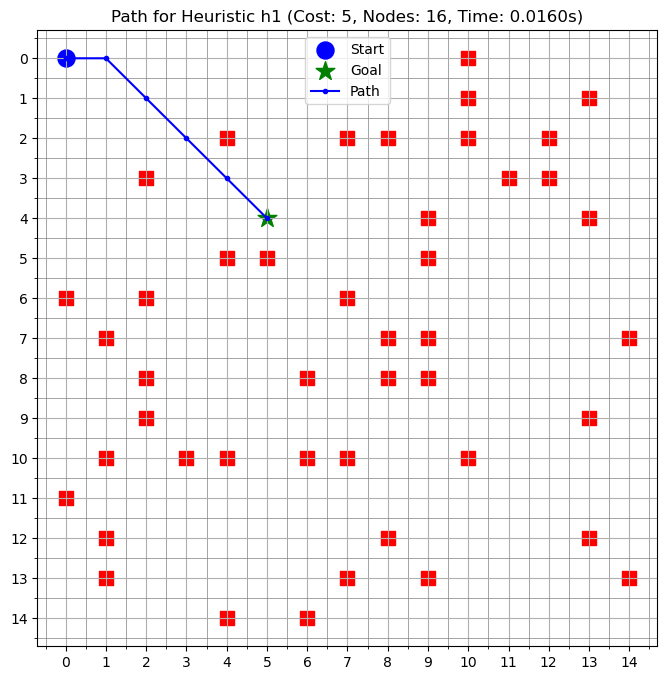

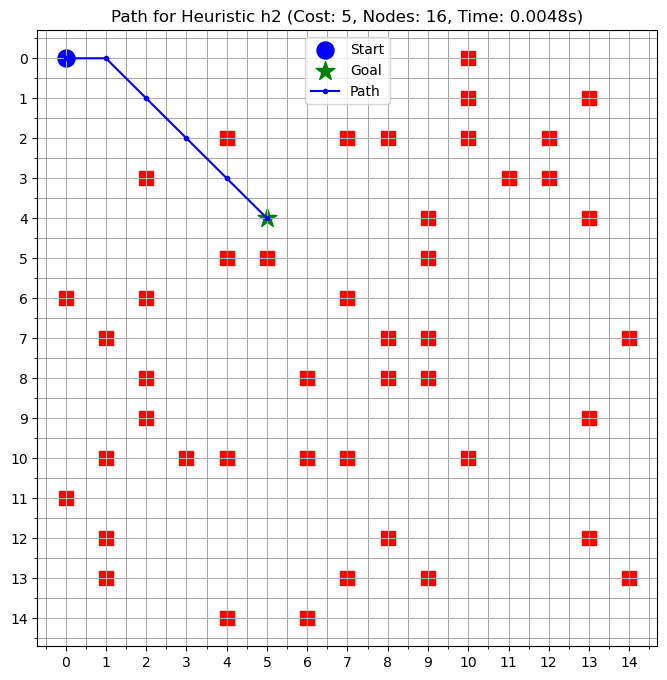

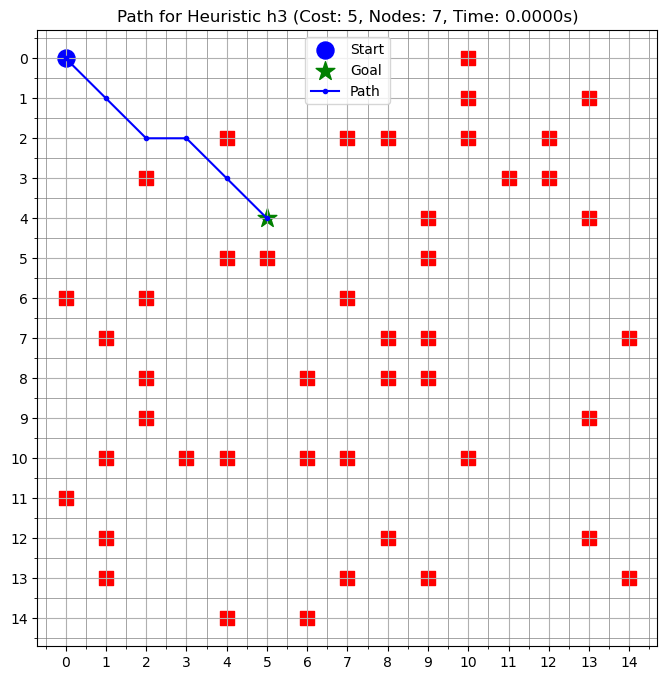

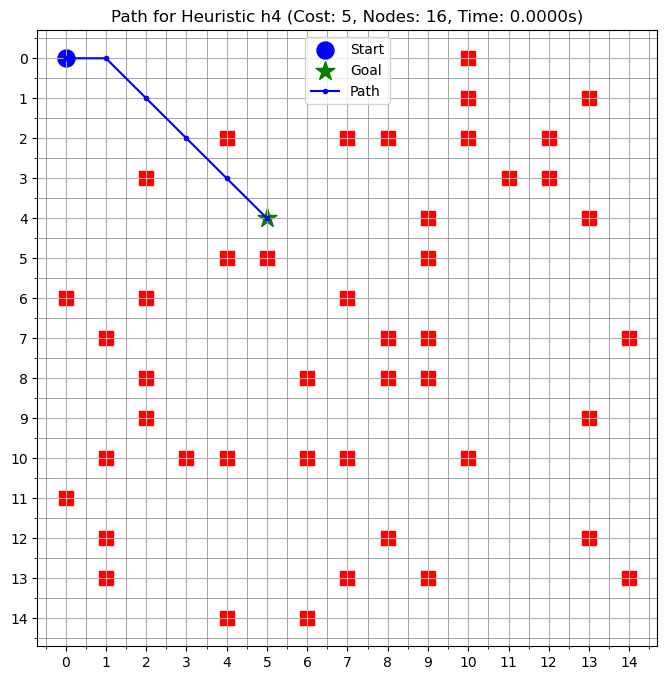

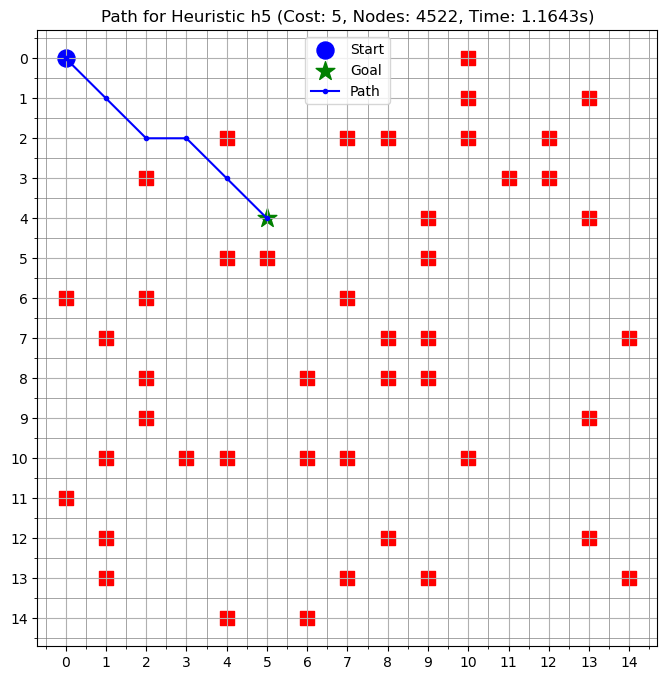

In [10]:
# Get user input for goal coordinates
try:
    goal_x = int(input("Enter goal x-coordinate (0-14): "))
    goal_y = int(input("Enter goal y-coordinate (0-14): "))
except ValueError:
    print("Invalid input. Using default goal (14, 14).")
    goal_x, goal_y = 14, 14

# Setup environment and initial state
env = Environment(goal_x, goal_y)
goal = env.goal
initial_visible_map = get_visible_map(0, 0, env)
initial_state = DroneState(
    x=0, y=0, fuel=INITIAL_FUEL, lives=INITIAL_LIVES, path_cost=0,
    known_no_fly_zones=set(), known_storm_map=set(), visible_map=initial_visible_map, time_step=0
)

# List of heuristics
heuristics = [h1, h2, h3, h4, h5]
results = {}

# Run A* with each heuristic
for h in heuristics:
    path_cost, nodes, exec_time, path = astar(initial_state, goal, h, env)
    results[h.__name__] = (path_cost, nodes, exec_time, path)

# Display results
print("Heuristic Comparison Results:")
for name, (cost, nodes, exec_time, path) in results.items():
    print(f"{name}: Path Cost = {cost}, Nodes Expanded = {nodes}, Time = {exec_time:.4f} seconds")

# Plot paths for each heuristic
for name, (cost, nodes, exec_time, path) in results.items():
    plt.figure(figsize=(8, 8))
    plt.title(f"Path for Heuristic {name} (Cost: {cost}, Nodes: {nodes}, Time: {exec_time:.4f}s)")

    # Plot grid
    plt.grid(True)
    plt.xticks(range(GRID_SIZE))
    plt.yticks(range(GRID_SIZE))
    plt.gca().set_xticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    plt.gca().set_yticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    plt.gca().grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

    # Plot mountains
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if env.get_terrain(i, j) == 'M':
                plt.scatter(j, i, c='red', marker='s', s=100, label='Mountain' if i == 0 and j == 0 else "")

    # Plot start and goal
    plt.scatter(0, 0, c='blue', marker='o', s=150, label='Start')
    plt.scatter(goal[1], goal[0], c='green', marker='*', s=200, label='Goal')

    # Plot path
    if path:
        path_x, path_y = zip(*path)
        plt.plot(path_y, path_x, 'b.-', label='Path')

    plt.legend()
    plt.gca().invert_yaxis()  # Match grid coordinates (0,0 at top-left)
    plt.show()

# Uniform Cost Search (UCS)
## Description:
    Baseline for cost-optimality, expands nodes with lowest path cost g(n).
    Data Structures:
        Priority queue ordered by g(n).
        Closed set to avoid revisiting states.

In [31]:
def ucs(state, goal, env):
    frontier = [(0, state)]  # (g(n), state)
    explored = set()
    while frontier:
        g, current = heapq.heappop(frontier)
        state_tuple = (current.x, current.y, current.fuel, current.lives, current.time_step)
        if (current.x, current.y) == goal:
            return current.path
        if state_tuple in explored:
            continue
        explored.add(state_tuple)
        for successor in get_successors(current, env):
            if (successor.x, successor.y, successor.fuel, successor.lives, successor.time_step) not in explored:
                heapq.heappush(frontier, (successor.path_cost, successor))
    return None

# Greedy Best-First Search
## Description:
    Expands nodes with lowest heuristic h(n), using two heuristics: h1 and h4.
# Data Structures:
    Priority queue ordered by h(n), no closed set (may revisit states).

In [32]:
def greedy_best_first(state, goal, heuristic, env):
    frontier = [(heuristic(state, goal), state)]  # (h(n), state)
    while frontier:
        _, current = heapq.heappop(frontier)
        if (current.x, current.y) == goal:
            return current.path
        for successor in get_successors(current, env):
            h = heuristic(successor, goal)
            heapq.heappush(frontier, (h, successor))
    return None

# A* Tree Search
## Description:
    Uses f(n) = g(n) + h(n), no closed set, may revisit states.
## Data Structures:
    Priority queue ordered by f(n).
Uses _h1_. The 30-step limit prevents infinite loops.

In [33]:
def a_star_tree(state, goal, heuristic, env):
    frontier = [(heuristic(state, goal), state)]  # (f(n), state)
    while frontier:
        _, current = heapq.heappop(frontier)
        if (current.x, current.y) == goal:
            return current.path
        for successor in get_successors(current, env):
            f = successor.path_cost + heuristic(successor, goal)
            heapq.heappush(frontier, (f, successor))
    return None

# A* Graph Search
## Description:
    Uses f(n) = g(n) + h(n), with a closed set, handles dynamic terrain updates via replanning.
## Data Structures:
    Priority queue ordered by f(n).
    Closed set to avoid revisiting states.

In [34]:
def a_star_graph(state, goal, heuristic, env):
    frontier = [(heuristic(state, goal), state)]  # (f(n), state)
    explored = set()
    while frontier:
        _, current = heapq.heappop(frontier)
        state_tuple = (current.x, current.y, current.fuel, current.lives, current.time_step)
        if (current.x, current.y) == goal:
            return current.path
        if state_tuple in explored:
            continue
        explored.add(state_tuple)
        for successor in get_successors(current, env):
            if (successor.x, successor.y, successor.fuel, successor.lives, successor.time_step) not in explored:
                f = successor.path_cost + heuristic(successor, goal)
                heapq.heappush(frontier, (f, successor))
    return None

# Simulation Loop:
    Start at step 0, drone at (0,0).
    For steps 0 to 30, in increments of 10:
        If step > 0 and step % 10 == 0, reshuffle terrain, update visible map, reset known hazards to current visible map.
        Run the search algorithm to plan a path.
        Follow the path for up to 10 steps or until goal is reached, updating state (position, fuel, lives, path cost).
        If a no-fly zone is entered (discovered during movement), mission fails.
    After 30 steps, check success.

In [35]:
def simulate(search_algorithm, state, goal, env, heuristic=None):
    current = state
    total_path = []
    for step in range(0, 31, 10):
        if step > 0:
            env.reshuffle()
            current.visible_map = get_visible_map(current.x, current.y, env)
            current.known_no_fly_zones = {(i,j) for (i,j),t in current.visible_map.items() if t == 'N'}
            current.known_storm_map = {(i,j) for (i,j),t in current.visible_map.items() if t == 'S'}
        kwargs = {'heuristic': heuristic} if heuristic else {}
        path = search_algorithm(current, goal, env, **kwargs)
        if not path:
            return False, total_path, current.path_cost
        for _ in range(min(10, 30 - step)):
            if not path:
                break
            next_pos = path[0]
            path = path[1:]
            current = move(current, next_pos, env)  # Updates state
            if env.grid[next_pos] == 'N':
                return False, total_path, current.path_cost
            total_path.append(next_pos)
            if next_pos == goal:
                return True, total_path, current.path_cost
    return False, total_path, current.path_cost

Choose an algorithm:
1. UCS
2. Greedy Best-First with h1
3. Greedy Best-First with h4
4. A* Tree Search with h1
5. A* Graph Search with h1
Path found with cost 6


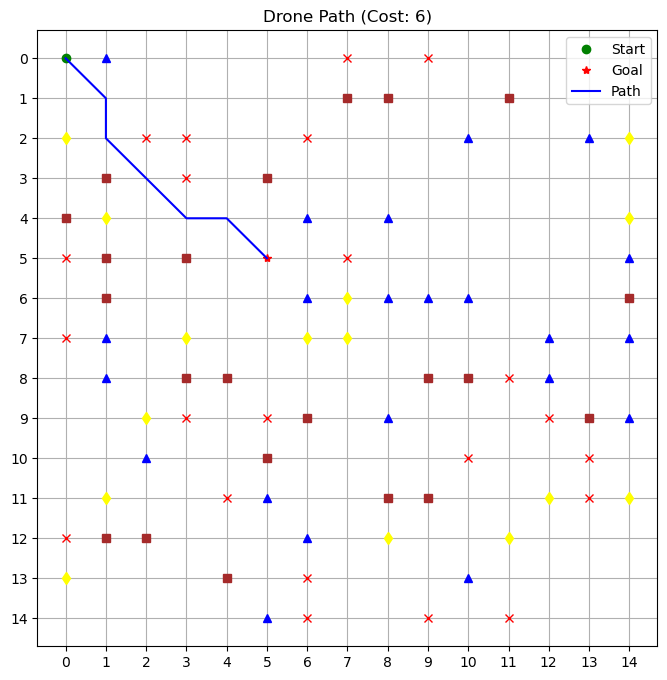

In [11]:
import random
import heapq
import matplotlib.pyplot as plt

class Environment:
    def __init__(self, goal_x, goal_y):
        self.grid = [['.' for _ in range(15)] for _ in range(15)]
        self.goal = (goal_x, goal_y)
        self.grid[goal_y][goal_x] = 'G'
        # Place 15 fuel stations
        fuel_positions = random.sample([(i,j) for i in range(15) for j in range(15) if (i,j) != (goal_x, goal_y) and (i,j) != (0,0)], 15)
        for pos in fuel_positions:
            self.grid[pos[1]][pos[0]] = 'E'
        # Place mountains in 10% of cells (reduced from 20%)
        num_mountains = int(0.1 * 15 * 15)
        mountain_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_mountains)
        for pos in mountain_positions:
            self.grid[pos[1]][pos[0]] = 'M'
        # Place no-fly zones in 10% of cells (reduced from 20%)
        num_nofly = int(0.1 * 15 * 15)
        nofly_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_nofly)
        for pos in nofly_positions:
            self.grid[pos[1]][pos[0]] = 'N'
        # Place storms in 10% of cells
        num_storms = int(0.1 * 15 * 15)
        storm_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_storms)
        for pos in storm_positions:
            self.grid[pos[1]][pos[0]] = 'S'

class DroneState:
    def __init__(self, x, y, fuel=100, lives=3, path_cost=0, path=None):  # Increased fuel to 100
        self.x = x
        self.y = y
        self.fuel = fuel
        self.lives = lives
        self.path_cost = path_cost
        self.path = path if path is not None else [(x, y)]
    def __lt__(self, other):
        return False

def get_successors(state, env):
    # Added diagonal moves
    moves = [(0,1), (1,0), (0,-1), (-1,0), (1,1), (1,-1), (-1,1), (-1,-1)]
    successors = []
    for dx, dy in moves:
        nx, ny = state.x + dx, state.y + dy
        if 0 <= nx < 15 and 0 <= ny < 15:
            terrain = env.grid[ny][nx]
            if terrain in ['M', 'N']:
                continue
            new_fuel = 10 if terrain == 'E' else state.fuel - 1
            lives_lost = 1 if terrain == 'S' else 0
            if new_fuel < 0:
                lives_lost += 1
            new_lives = state.lives - lives_lost
            if new_lives <= 0:
                continue
            new_path_cost = state.path_cost + 1 + 10 * lives_lost
            new_path = state.path + [(nx, ny)]
            successors.append(DroneState(nx, ny, new_fuel, new_lives, new_path_cost, new_path))
    return successors

def h1(state, goal):
    return max(abs(state.x - goal[0]), abs(state.y - goal[1]))

def h4(state, goal):
    d = h1(state, goal)
    return d + 2 if state.fuel < 5 else d

def ucs(initial_state, goal, env):
    frontier = [(0, initial_state)]
    explored = set()
    while frontier:
        g, current = heapq.heappop(frontier)
        if (current.x, current.y) == goal:
            return current.path, current.path_cost
        state_key = (current.x, current.y, current.fuel, current.lives)
        if state_key in explored:
            continue
        explored.add(state_key)
        for successor in get_successors(current, env):
            if (successor.x, successor.y, successor.fuel, successor.lives) not in explored:
                heapq.heappush(frontier, (successor.path_cost, successor))
    return None

def greedy_best_first(initial_state, goal, heuristic, env):
    frontier = [(heuristic(initial_state, goal), initial_state)]
    explored = set()
    while frontier:
        _, current = heapq.heappop(frontier)
        if (current.x, current.y) == goal:
            return current.path, current.path_cost
        state_key = (current.x, current.y, current.fuel, current.lives)
        if state_key in explored:
            continue
        explored.add(state_key)
        for successor in get_successors(current, env):
            h = heuristic(successor, goal)
            heapq.heappush(frontier, (h, successor))
    return None

def a_star_tree(initial_state, goal, heuristic, env):
    frontier = [(heuristic(initial_state, goal), initial_state)]
    while frontier:
        _, current = heapq.heappop(frontier)
        if (current.x, current.y) == goal:
            return current.path, current.path_cost
        for successor in get_successors(current, env):
            f = successor.path_cost + heuristic(successor, goal)
            heapq.heappush(frontier, (f, successor))
    return None

def a_star_graph(initial_state, goal, heuristic, env):
    frontier = [(heuristic(initial_state, goal), initial_state)]
    explored = set()
    while frontier:
        _, current = heapq.heappop(frontier)
        if (current.x, current.y) == goal:
            return current.path, current.path_cost
        state_key = (current.x, current.y, current.fuel, current.lives)
        if state_key in explored:
            continue
        explored.add(state_key)
        for successor in get_successors(current, env):
            if (successor.x, successor.y, successor.fuel, successor.lives) not in explored:
                f = successor.path_cost + heuristic(successor, goal)
                heapq.heappush(frontier, (f, successor))
    return None

def run_selected_algorithm():
    print("Choose an algorithm:")
    print("1. UCS")
    print("2. Greedy Best-First with h1")
    print("3. Greedy Best-First with h4")
    print("4. A* Tree Search with h1")
    print("5. A* Graph Search with h1")
    try:
        choice = int(input("Enter choice (1-5): "))
    except ValueError:
        print("Invalid choice")
        return
    algorithms = {
        1: (ucs, None),
        2: (greedy_best_first, h1),
        3: (greedy_best_first, h4),
        4: (a_star_tree, h1),
        5: (a_star_graph, h1)
    }
    algorithm, heuristic = algorithms.get(choice, (None, None))
    if not algorithm:
        print("Invalid choice")
        return
    try:
        goal_x = int(input("Goal x (0-14): "))
        goal_y = int(input("Goal y (0-14): "))
        if not (0 <= goal_x <= 14 and 0 <= goal_y <= 14):
            print("Invalid coordinates")
            return
    except ValueError:
        print("Invalid input")
        return
    env = Environment(goal_x, goal_y)
    initial_state = DroneState(0, 0)
    goal = (goal_x, goal_y)
    if heuristic:
        result = algorithm(initial_state, goal, heuristic, env)
    else:
        result = algorithm(initial_state, goal, env)
    if result:
        path, path_cost = result
        print(f"Path found with cost {path_cost}")
        plt.figure(figsize=(8,8))
        plt.title(f"Drone Path (Cost: {path_cost})")
        plt.grid(True)
        plt.xticks(range(15))
        plt.yticks(range(15))
        for y in range(15):
            for x in range(15):
                terrain = env.grid[y][x]
                if terrain == 'M':
                    plt.plot(x, y, 's', color='brown', label='Mountain' if x == 0 and y == 0 else '')
                elif terrain == 'N':
                    plt.plot(x, y, 'x', color='red', label='No-Fly Zone' if x == 0 and y == 0 else '')
                elif terrain == 'S':
                    plt.plot(x, y, '^', color='blue', label='Storm' if x == 0 and y == 0 else '')
                elif terrain == 'E':
                    plt.plot(x, y, 'd', color='yellow', label='Fuel Station' if x == 0 and y == 0 else '')
        plt.plot(0, 0, 'go', label='Start')
        plt.plot(goal_x, goal_y, 'r*', label='Goal')
        if path:
            path_x, path_y = zip(*path)
            plt.plot(path_x, path_y, 'b-', label='Path')
        plt.legend()
        plt.gca().invert_yaxis()
        plt.show()
    else:
        print("No path found")
        # Print grid for debugging
        for row in env.grid:
            print(' '.join(row))

if __name__ == "__main__":
    run_selected_algorithm()

# Task 5 :

Enter goal coordinates (will be hidden until discovered):
Failed to reach goal
N . M . . . . M M N . N . N S
N . . . . . . . . . . . S . .
M . . . . N . N . . M . . . .
. . . . . E S . E M S . S . .
. . . N . G M . . . . . M E S
. . S . . . M S N . S . M . M
. . . . S S . . N S . N . . S
. N . . S . . N . . . M . . M
. . E . . . S . E . M S . . .
. . . N . N . . . E . . . E .
S E S . . S . . . . M N . M .
M . . M E N . . . . E . N N .
N . . . . S . E N . S . S M .
. . . . . . E . E . . E . . N
. M . . . . E . . . M . . . M


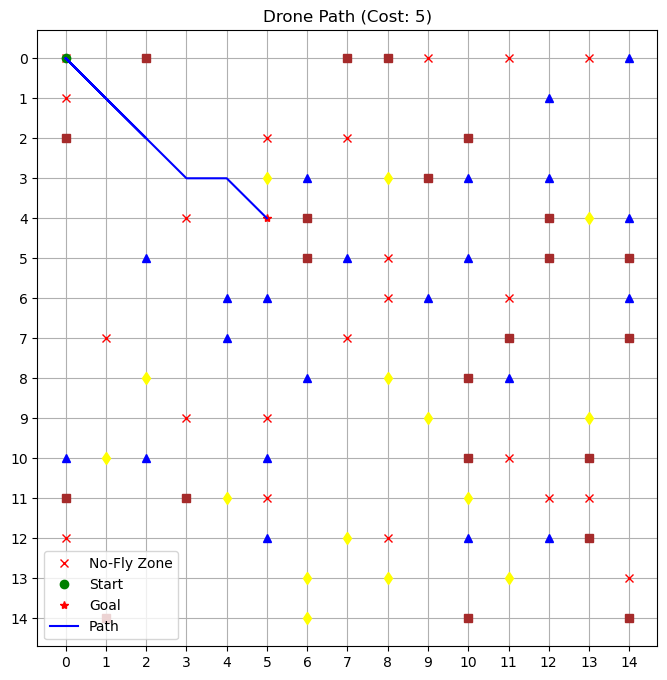

In [14]:
import random
import heapq
import matplotlib.pyplot as plt

class Environment:
    def __init__(self, goal_x, goal_y):
        self.grid = [['.' for _ in range(15)] for _ in range(15)]
        self.goal = (goal_x, goal_y)
        self.grid[goal_y][goal_x] = 'G'
        # Place 15 fuel stations
        fuel_positions = random.sample([(i,j) for i in range(15) for j in range(15) if (i,j) != (goal_x, goal_y) and (i,j) != (0,0)], 15)
        for pos in fuel_positions:
            self.grid[pos[1]][pos[0]] = 'E'
        # Place mountains in 10% of cells
        num_mountains = int(0.1 * 15 * 15)
        mountain_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_mountains)
        for pos in mountain_positions:
            self.grid[pos[1]][pos[0]] = 'M'
        # Place no-fly zones in 10% of cells
        num_nofly = int(0.1 * 15 * 15)
        nofly_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_nofly)
        for pos in nofly_positions:
            self.grid[pos[1]][pos[0]] = 'N'
        # Place storms in 10% of cells
        num_storms = int(0.1 * 15 * 15)
        storm_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_storms)
        for pos in storm_positions:
            self.grid[pos[1]][pos[0]] = 'S'

class DroneState:
    def __init__(self, x, y, fuel=100, lives=3, path_cost=0, path=None, known_goal=None, visible_map=None, seen_cells=None):
        self.x = x
        self.y = y
        self.fuel = fuel
        self.lives = lives
        self.path_cost = path_cost
        self.path = path if path is not None else [(x, y)]
        self.known_goal = known_goal
        self.visible_map = visible_map if visible_map is not None else {}
        self.seen_cells = seen_cells if seen_cells is not None else set([(x, y)])
    def __lt__(self, other):
        return False

def get_visible_map(x, y, env):
    visible = {}
    for i in range(max(0, x - 2), min(15, x + 3)):
        for j in range(max(0, y - 2), min(15, y + 3)):
            if max(abs(i - x), abs(j - y)) <= 2:
                visible[(i, j)] = env.grid[j][i]
    return visible

def get_successors(state, env):
    moves = [(0,1), (1,0), (0,-1), (-1,0), (1,1), (1,-1), (-1,1), (-1,-1)]
    successors = []
    for dx, dy in moves:
        nx, ny = state.x + dx, state.y + dy
        if 0 <= nx < 15 and 0 <= ny < 15:
            terrain = env.grid[ny][nx]
            if terrain in ['M', 'N']:
                continue
            new_fuel = 10 if terrain == 'E' else state.fuel - 1
            lives_lost = 1 if terrain == 'S' else 0
            if new_fuel < 0:
                lives_lost += 1
            new_lives = state.lives - lives_lost
            if new_lives <= 0:
                continue
            new_path_cost = state.path_cost + 1 + 10 * lives_lost
            new_path = state.path + [(nx, ny)]
            new_visible_map = get_visible_map(nx, ny, env)
            new_known_goal = state.known_goal
            if not new_known_goal and new_visible_map.get(env.goal) == 'G':
                new_known_goal = env.goal
            new_seen_cells = state.seen_cells | set(new_visible_map.keys())
            successors.append(DroneState(nx, ny, new_fuel, new_lives, new_path_cost, new_path, new_known_goal, new_visible_map, new_seen_cells))
    return successors

def h1(state, goal):
    return max(abs(state.x - goal[0]), abs(state.y - goal[1]))

def explore_one_step(state, env):
    """Choose a move to maximize unseen cells."""
    successors = get_successors(state, env)
    if not successors:
        return None
    # Score successors by number of new cells they reveal
    best_successor = None
    max_new_cells = -1
    for successor in successors:
        new_cells = len(successor.seen_cells - state.seen_cells)
        if new_cells > max_new_cells:
            max_new_cells = new_cells
            best_successor = successor
    return best_successor

def a_star_graph(initial_state, goal, heuristic, env):
    frontier = [(heuristic(initial_state, goal), initial_state)]
    explored = set()
    while frontier:
        _, current = heapq.heappop(frontier)
        if (current.x, current.y) == goal:
            return current.path, current.path_cost
        state_key = (current.x, current.y, current.fuel, current.lives)
        if state_key in explored:
            continue
        explored.add(state_key)
        for successor in get_successors(current, env):
            if (successor.x, successor.y, successor.fuel, successor.lives) not in explored:
                f = successor.path_cost + heuristic(successor, goal)
                heapq.heappush(frontier, (f, successor))
    return None, 0

def run_dynamic_goal_simulation():
    print("Enter goal coordinates (will be hidden until discovered):")
    try:
        goal_x = int(input("Goal x (0-14): "))
        goal_y = int(input("Goal y (0-14): "))
        if not (0 <= goal_x <= 14 and 0 <= goal_y <= 14):
            print("Invalid coordinates")
            return
    except ValueError:
        print("Invalid input")
        return
    env = Environment(goal_x, goal_y)
    initial_visible_map = get_visible_map(0, 0, env)
    initial_state = DroneState(0, 0, visible_map=initial_visible_map)
    current_state = initial_state
    total_path = [(0, 0)]
    total_cost = 0
    max_steps = 1000  # Prevent infinite loops
    step = 0
    while current_state.lives > 0 and current_state.fuel >= 0 and step < max_steps:
        if current_state.known_goal:
            # Goal is known, use A* Graph Search
            path, path_cost = a_star_graph(current_state, current_state.known_goal, h1, env)
            if path:
                total_path = current_state.path[:-1] + path  # Combine exploration and A* paths
                total_cost = path_cost
                break
            else:
                print("No path found to goal")
                break
        else:
            # Goal unknown, take one exploration step
            next_state = explore_one_step(current_state, env)
            if not next_state:
                print("No valid moves during exploration")
                break
            current_state = next_state
            total_path = current_state.path
            total_cost = current_state.path_cost
            step += 1
    if (current_state.x, current_state.y) == env.goal:
        print(f"Goal reached with cost {total_cost}")
    else:
        print("Failed to reach goal")
        # Print grid for debugging
        for row in env.grid:
            print(' '.join(row))
    # Plotting
    plt.figure(figsize=(8,8))
    plt.title(f"Drone Path (Cost: {total_cost})")
    plt.grid(True)
    plt.xticks(range(15))
    plt.yticks(range(15))
    for y in range(15):
        for x in range(15):
            terrain = env.grid[y][x]
            if terrain == 'M':
                plt.plot(x, y, 's', color='brown', label='Mountain' if x == 0 and y == 0 else '')
            elif terrain == 'N':
                plt.plot(x, y, 'x', color='red', label='No-Fly Zone' if x == 0 and y == 0 else '')
            elif terrain == 'S':
                plt.plot(x, y, '^', color='blue', label='Storm' if x == 0 and y == 0 else '')
            elif terrain == 'E':
                plt.plot(x, y, 'd', color='yellow', label='Fuel Station' if x == 0 and y == 0 else '')
    plt.plot(0, 0, 'go', label='Start')
    plt.plot(goal_x, goal_y, 'r*', label='Goal')
    if total_path:
        path_x, path_y = zip(*total_path)
        plt.plot(path_x, path_y, 'b-', label='Path')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.show()

if __name__ == "__main__":
    run_dynamic_goal_simulation()

# Task 6 : ##

In [16]:
import random
import heapq
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

class Environment:
    def __init__(self, goal_x, goal_y):
        self.grid = [['.' for _ in range(15)] for _ in range(15)]
        self.goal = (goal_x, goal_y)
        self.grid[goal_y][goal_x] = 'G'
        fuel_positions = random.sample([(i,j) for i in range(15) for j in range(15) if (i,j) != (goal_x, goal_y) and (i,j) != (0,0)], 15)
        for pos in fuel_positions:
            self.grid[pos[1]][pos[0]] = 'E'
        num_mountains = int(0.1 * 15 * 15)
        mountain_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_mountains)
        for pos in mountain_positions:
            self.grid[pos[1]][pos[0]] = 'M'
        num_nofly = int(0.1 * 15 * 15)
        nofly_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_nofly)
        for pos in nofly_positions:
            self.grid[pos[1]][pos[0]] = 'N'
        num_storms = int(0.1 * 15 * 15)
        storm_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_storms)
        for pos in storm_positions:
            self.grid[pos[1]][pos[0]] = 'S'

class DroneState:
    def __init__(self, x, y, fuel=100, lives=3, path_cost=0, path=None, known_goal=None, visible_map=None, seen_cells=None):
        self.x = x
        self.y = y
        self.fuel = fuel
        self.lives = lives
        self.path_cost = path_cost
        self.path = path if path is not None else [(x, y)]
        self.known_goal = known_goal
        self.visible_map = visible_map if visible_map is not None else {}
        self.seen_cells = seen_cells if seen_cells is not None else set([(x, y)])
    def __lt__(self, other):
        return False

def get_visible_map(x, y, env):
    visible = {}
    for i in range(max(0, x - 2), min(15, x + 3)):
        for j in range(max(0, y - 2), min(15, y + 3)):
            if max(abs(i - x), abs(j - y)) <= 2:
                visible[(i, j)] = env.grid[j][i]
    return visible

def get_successors(state, env, nodes_expanded):
    moves = [(0,1), (1,0), (0,-1), (-1,0), (1,1), (1,-1), (-1,1), (-1,-1)]
    successors = []
    for dx, dy in moves:
        nx, ny = state.x + dx, state.y + dy
        if 0 <= nx < 15 and 0 <= ny < 15:
            terrain = env.grid[ny][nx]
            if terrain in ['M', 'N']:
                continue
            new_fuel = 10 if terrain == 'E' else state.fuel - 1
            lives_lost = 1 if terrain == 'S' else 0
            if new_fuel < 0:
                lives_lost += 1
            new_lives = state.lives - lives_lost
            if new_lives <= 0:
                continue
            new_path_cost = state.path_cost + 1 + 10 * lives_lost
            new_path = state.path + [(nx, ny)]
            new_visible_map = get_visible_map(nx, ny, env)
            new_known_goal = state.known_goal
            if not new_known_goal and new_visible_map.get(env.goal) == 'G':
                new_known_goal = env.goal
            new_seen_cells = state.seen_cells | set(new_visible_map.keys())
            successors.append(DroneState(nx, ny, new_fuel, new_lives, new_path_cost, new_path, new_known_goal, new_visible_map, new_seen_cells))
    nodes_expanded[0] += len(successors)
    return successors

def h1(state, goal):
    return max(abs(state.x - goal[0]), abs(state.y - goal[1]))

def explore_one_step(state, env, nodes_expanded):
    successors = get_successors(state, env, nodes_expanded)
    if not successors:
        return None
    best_successor = None
    max_new_cells = -1
    for successor in successors:
        new_cells = len(successor.seen_cells - state.seen_cells)
        if new_cells > max_new_cells:
            max_new_cells = new_cells
            best_successor = successor
    return best_successor

def a_star_graph(initial_state, goal, heuristic, env, nodes_expanded):
    frontier = [(heuristic(initial_state, goal), initial_state)]
    explored = set()
    while frontier:
        _, current = heapq.heappop(frontier)
        nodes_expanded[0] += 1
        if (current.x, current.y) == goal:
            return current.path, current.path_cost
        state_key = (current.x, current.y, current.fuel, current.lives)
        if state_key in explored:
            continue
        explored.add(state_key)
        for successor in get_successors(current, env, nodes_expanded):
            if (successor.x, successor.y, successor.fuel, successor.lives) not in explored:
                f = successor.path_cost + heuristic(successor, goal)
                heapq.heappush(frontier, (f, successor))
    return None, 0

def plot_grid(state, env, total_path, goal_known, nodes_expanded, log_entry):
    plt.figure(figsize=(20, 5))

    # Main grid
    plt.subplot(1, 4, 1)
    plt.title(f"Drone Position: ({state.x}, {state.y})\nFuel: {state.fuel}, Lives: {state.lives}, Nodes: {nodes_expanded[0]}")
    plt.grid(True)
    plt.xticks(range(15))
    plt.yticks(range(15))
    # Fog-of-war: gray out unseen cells
    for y in range(15):
        for x in range(15):
            if (x, y) not in state.seen_cells:
                plt.fill([x, x+1, x+1, x], [y, y, y+1, y+1], 'gray', alpha=0.5)
            else:
                terrain = env.grid[y][x]
                if terrain == 'M':
                    plt.plot(x, y, 's', color='brown', label='Mountain' if x == 0 and y == 0 else '')
                elif terrain == 'N':
                    plt.plot(x, y, 'x', color='red', label='No-Fly Zone' if x == 0 and y == 0 else '')
                elif terrain == 'S':
                    plt.plot(x, y, '^', color='blue', label='Storm' if x == 0 and y == 0 else '')
                elif terrain == 'E':
                    plt.plot(x, y, 'd', color='yellow', label='Fuel Station' if x == 0 and y == 0 else '')
                elif terrain == 'G' and goal_known:
                    plt.plot(x, y, 'r*', label='Goal' if x == 0 and y == 0 else '')
    plt.plot(0, 0, 'go', label='Start')
    if total_path:
        path_x, path_y = zip(*total_path)
        plt.plot(path_x, path_y, 'b-', label='Path')
    plt.legend()
    plt.gca().invert_yaxis()

    # Heuristic visualization (only when goal is known)
    if state.known_goal:
        h_map = np.zeros((15, 15))
        g_map = np.zeros((15, 15))
        f_map = np.zeros((15, 15))
        for x in range(15):
            for y in range(15):
                temp_state = DroneState(x, y, fuel=state.fuel, lives=state.lives, path_cost=state.path_cost)
                h_map[y, x] = h1(temp_state, state.known_goal)
                g_map[y, x] = state.path_cost  # Approximate, ideally path-specific
                f_map[y, x] = g_map[y, x] + h_map[y, x]

        # h(n) heatmap
        plt.subplot(1, 4, 2)
        plt.title("h(n): Chebyshev Distance")
        plt.imshow(h_map, cmap='viridis', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        # g(n) heatmap
        plt.subplot(1, 4, 3)
        plt.title("g(n): Path Cost")
        plt.imshow(g_map, cmap='plasma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        # f(n) heatmap
        plt.subplot(1, 4, 4)
        plt.title("f(n): Estimated Total Cost")
        plt.imshow(f_map, cmap='magma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

    plt.tight_layout()
    plt.show()
    clear_output(wait=True)
    print(f"Step Log: {log_entry}")

def run_dynamic_goal_simulation():
    print("Enter goal coordinates (will be hidden until discovered):")
    try:
        goal_x = int(input("Goal x (0-14): "))
        goal_y = int(input("Goal y (0-14): "))
        if not (0 <= goal_x <= 14 and 0 <= goal_y <= 14):
            print("Invalid coordinates")
            return
    except ValueError:
        print("Invalid input")
        return
    env = Environment(goal_x, goal_y)
    initial_visible_map = get_visible_map(0, 0, env)
    initial_state = DroneState(0, 0, visible_map=initial_visible_map)
    current_state = initial_state
    total_path = [(0, 0)]
    total_cost = 0
    nodes_expanded = [0]  # Mutable to track across searches
    max_steps = 1000
    step = 0
    logs = []
    replanning_triggered = False

    while current_state.lives > 0 and current_state.fuel >= 0 and step < max_steps:
        action = "Explore"
        if current_state.known_goal and not replanning_triggered:
            action = "Replan to goal"
            replanning_triggered = True
            logs.append(f"Step {step}: Replanning triggered at ({current_state.x}, {current_state.y})")
            path, path_cost = a_star_graph(current_state, current_state.known_goal, h1, env, nodes_expanded)
            if path:
                total_path = current_state.path[:-1] + path
                total_cost = path_cost
                current_state = DroneState(
                    path[-1][0], path[-1][1], current_state.fuel, current_state.lives,
                    path_cost, total_path, current_state.known_goal, current_state.visible_map, current_state.seen_cells
                )
            else:
                logs.append(f"Step {step}: No path found to goal")
                break
        else:
            next_state = explore_one_step(current_state, env, nodes_expanded)
            if not next_state:
                logs.append(f"Step {step}: No valid moves at ({current_state.x}, {current_state.y})")
                break
            direction = (next_state.x - current_state.x, next_state.y - current_state.y)
            action = f"Move {direction}"
            current_state = next_state
            total_path = current_state.path
            total_cost = current_state.path_cost
            step += 1

        log_entry = f"Step {step}: Pos=({current_state.x}, {current_state.y}), Action={action}, Fuel={current_state.fuel}, Lives={current_state.lives}"
        logs.append(log_entry)
        plot_grid(current_state, env, total_path, current_state.known_goal is not None, nodes_expanded, log_entry)
        time.sleep(0.1)  # Slow down animation for visibility

    success = (current_state.x, current_state.y) == env.goal
    plt.figure(figsize=(10, 8))
    plt.title("MISSION ACCOMPLISHED" if success else "MISSION FAILED")
    plt.text(0.5, 0.5, f"Lives: {current_state.lives}\nFuel: {current_state.fuel}\nNodes Expanded: {nodes_expanded[0]}",
             fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
    plt.axis('off')
    plt.show()
    clear_output(wait=True)

    print("\n=== Mission Log ===")
    for log in logs:
        print(log)
    print(f"\nFinal Status: {'Success' if success else 'Failure'}")
    print(f"Lives: {current_state.lives}, Fuel: {current_state.fuel}, Nodes Expanded: {nodes_expanded[0]}")
    if not success:
        print("\nGrid for Debugging:")
        for row in env.grid:
            print(' '.join(row))

    # Final plot
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title(f"Final Path (Cost: {total_cost})")
    plt.grid(True)
    plt.xticks(range(15))
    plt.yticks(range(15))
    for y in range(15):
        for x in range(15):
            if (x, y) not in current_state.seen_cells:
                plt.fill([x, x+1, x+1, x], [y, y, y+1, y+1], 'gray', alpha=0.5)
            else:
                terrain = env.grid[y][x]
                if terrain == 'M':
                    plt.plot(x, y, 's', color='brown', label='Mountain' if x == 0 and y == 0 else '')
                elif terrain == 'N':
                    plt.plot(x, y, 'x', color='red', label='No-Fly Zone' if x == 0 and y == 0 else '')
                elif terrain == 'S':
                    plt.plot(x, y, '^', color='blue', label='Storm' if x == 0 and y == 0 else '')
                elif terrain == 'E':
                    plt.plot(x, y, 'd', color='yellow', label='Fuel Station' if x == 0 and y == 0 else '')
                elif terrain == 'G':
                    plt.plot(x, y, 'r*', label='Goal')
    plt.plot(0, 0, 'go', label='Start')
    if total_path:
        path_x, path_y = zip(*total_path)
        plt.plot(path_x, path_y, 'b-', label='Path')
    plt.legend()
    plt.gca().invert_yaxis()

    if current_state.known_goal:
        h_map = np.zeros((15, 15))
        g_map = np.zeros((15, 15))
        f_map = np.zeros((15, 15))
        for x in range(15):
            for y in range(15):
                temp_state = DroneState(x, y, fuel=current_state.fuel, lives=current_state.lives, path_cost=current_state.path_cost)
                h_map[y, x] = h1(temp_state, current_state.known_goal)
                g_map[y, x] = current_state.path_cost
                f_map[y, x] = g_map[y, x] + h_map[y, x]

        plt.subplot(1, 4, 2)
        plt.title("h(n): Chebyshev Distance")
        plt.imshow(h_map, cmap='viridis', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 3)
        plt.title("g(n): Path Cost")
        plt.imshow(g_map, cmap='plasma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 4)
        plt.title("f(n): Estimated Total Cost")
        plt.imshow(f_map, cmap='magma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_dynamic_goal_simulation()

KeyboardInterrupt: 

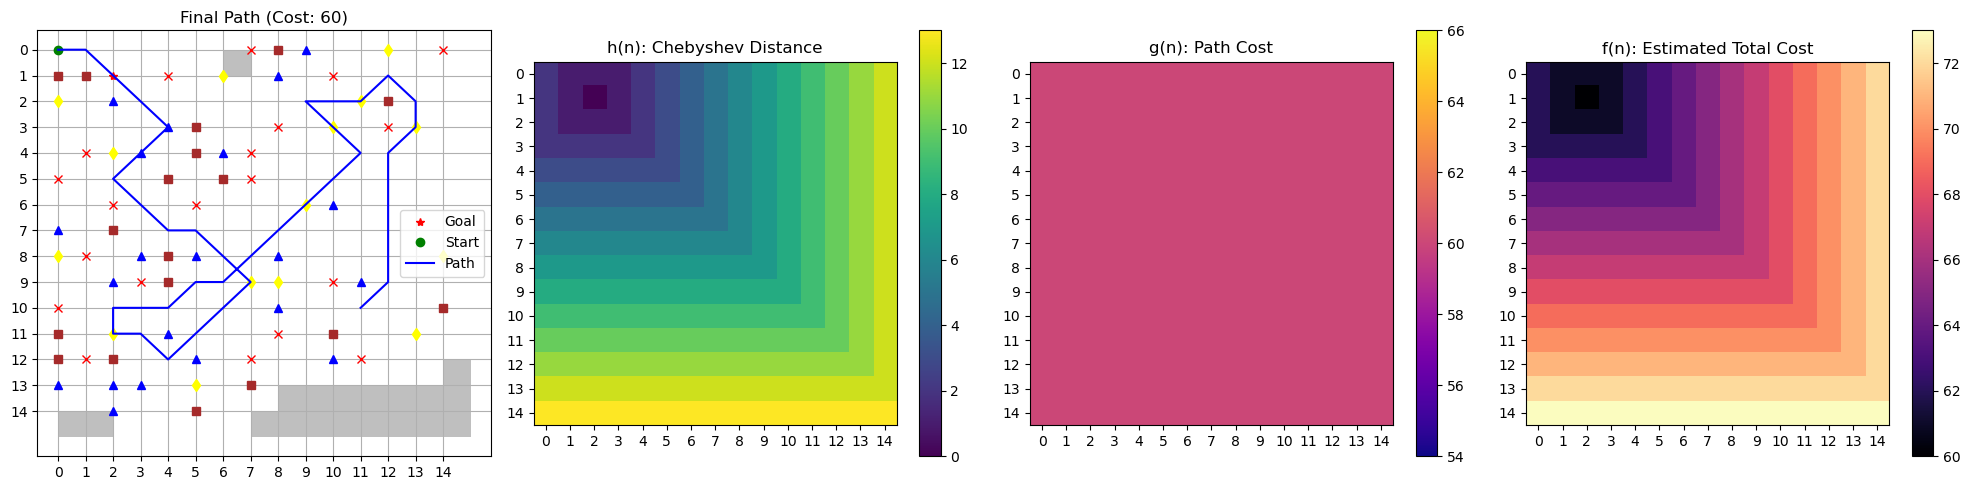

In [18]:
import random
import heapq
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

class Environment:
    def __init__(self, goal_x, goal_y):
        self.grid = [['.' for _ in range(15)] for _ in range(15)]
        self.goal = (goal_x, goal_y)
        self.grid[goal_y][goal_x] = 'G'
        fuel_positions = random.sample([(i,j) for i in range(15) for j in range(15) if (i,j) != (goal_x, goal_y) and (i,j) != (0,0)], 15)
        for pos in fuel_positions:
            self.grid[pos[1]][pos[0]] = 'E'
        num_mountains = int(0.1 * 15 * 15)
        mountain_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_mountains)
        for pos in mountain_positions:
            self.grid[pos[1]][pos[0]] = 'M'
        num_nofly = int(0.1 * 15 * 15)
        nofly_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_nofly)
        for pos in nofly_positions:
            self.grid[pos[1]][pos[0]] = 'N'
        num_storms = int(0.1 * 15 * 15)
        storm_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_storms)
        for pos in storm_positions:
            self.grid[pos[1]][pos[0]] = 'S'

class DroneState:
    def __init__(self, x, y, fuel=100, lives=3, path_cost=0, path=None, known_goal=None, visible_map=None, seen_cells=None):
        self.x = x
        self.y = y
        self.fuel = fuel
        self.lives = lives
        self.path_cost = path_cost
        self.path = path if path is not None else [(x, y)]
        self.known_goal = known_goal
        self.visible_map = visible_map if visible_map is not None else {}
        self.seen_cells = seen_cells if seen_cells is not None else set([(x, y)])
    def __lt__(self, other):
        return False

def get_visible_map(x, y, env):
    visible = {}
    for i in range(max(0, x - 2), min(15, x + 3)):
        for j in range(max(0, y - 2), min(15, y + 3)):
            if max(abs(i - x), abs(j - y)) <= 2:
                visible[(i, j)] = env.grid[j][i]
    return visible

def get_successors(state, env, nodes_expanded):
    moves = [(0,1), (1,0), (0,-1), (-1,0), (1,1), (1,-1), (-1,1), (-1,-1)]
    successors = []
    for dx, dy in moves:
        nx, ny = state.x + dx, state.y + dy
        if 0 <= nx < 15 and 0 <= ny < 15:
            terrain = env.grid[ny][nx]
            if terrain in ['M', 'N']:
                continue
            new_fuel = 10 if terrain == 'E' else state.fuel - 1
            lives_lost = 1 if terrain == 'S' else 0
            if new_fuel < 0:
                lives_lost += 1
            new_lives = state.lives - lives_lost
            if new_lives <= 0:
                continue
            new_path_cost = state.path_cost + 1 + 10 * lives_lost
            new_path = state.path + [(nx, ny)]
            new_visible_map = get_visible_map(nx, ny, env)
            new_known_goal = state.known_goal
            if not new_known_goal and new_visible_map.get(env.goal) == 'G':
                new_known_goal = env.goal
            new_seen_cells = state.seen_cells | set(new_visible_map.keys())
            successors.append(DroneState(nx, ny, new_fuel, new_lives, new_path_cost, new_path, new_known_goal, new_visible_map, new_seen_cells))
    nodes_expanded[0] += len(successors)
    return successors

def h1(state, goal):
    return max(abs(state.x - goal[0]), abs(state.y - goal[1]))

def explore_one_step(state, env, nodes_expanded, visited):
    successors = get_successors(state, env, nodes_expanded)
    if not successors:
        return None
    best_successor = None
    max_new_cells = -1
    min_distance_to_center = float('inf')
    center = (7, 7)  # Grid center
    for successor in successors:
        new_cells = len(successor.seen_cells - state.seen_cells)
        distance_to_center = max(abs(successor.x - center[0]), abs(successor.y - center[1]))
        if (successor.x, successor.y) in visited:
            continue
        if new_cells > max_new_cells or (new_cells == max_new_cells and distance_to_center < min_distance_to_center):
            max_new_cells = new_cells
            min_distance_to_center = distance_to_center
            best_successor = successor
    return best_successor

def a_star_graph(initial_state, goal, heuristic, env, nodes_expanded):
    frontier = [(heuristic(initial_state, goal), initial_state)]
    explored = set()
    while frontier:
        _, current = heapq.heappop(frontier)
        nodes_expanded[0] += 1
        if (current.x, current.y) == goal:
            return current.path, current.path_cost
        state_key = (current.x, current.y, current.fuel, current.lives)
        if state_key in explored:
            continue
        explored.add(state_key)
        for successor in get_successors(current, env, nodes_expanded):
            if (successor.x, successor.y, successor.fuel, successor.lives) not in explored:
                f = successor.path_cost + heuristic(successor, goal)
                heapq.heappush(frontier, (f, successor))
    return None, 0

def plot_grid(state, env, total_path, goal_known, nodes_expanded, log_entry, step):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.title(f"Step {step}: Pos ({state.x}, {state.y})\nFuel: {state.fuel}, Lives: {state.lives}, Nodes: {nodes_expanded[0]}")
    plt.grid(True)
    plt.xticks(range(15))
    plt.yticks(range(15))
    for y in range(15):
        for x in range(15):
            if (x, y) not in state.seen_cells:
                plt.fill([x, x+1, x+1, x], [y, y, y+1, y+1], 'gray', alpha=0.5)
            else:
                terrain = env.grid[y][x]
                if terrain == 'M':
                    plt.plot(x, y, 's', color='brown', label='Mountain' if x == 0 and y == 0 else '')
                elif terrain == 'N':
                    plt.plot(x, y, 'x', color='red', label='No-Fly Zone' if x == 0 and y == 0 else '')
                elif terrain == 'S':
                    plt.plot(x, y, '^', color='blue', label='Storm' if x == 0 and y == 0 else '')
                elif terrain == 'E':
                    plt.plot(x, y, 'd', color='yellow', label='Fuel Station' if x == 0 and y == 0 else '')
                elif terrain == 'G' and goal_known:
                    plt.plot(x, y, 'r*', label='Goal' if x == 0 and y == 0 else '')
    plt.plot(0, 0, 'go', label='Start')
    if total_path:
        path_x, path_y = zip(*total_path)
        plt.plot(path_x, path_y, 'b-', label='Path')
    plt.legend()
    plt.gca().invert_yaxis()

    if state.known_goal:
        h_map = np.zeros((15, 15))
        g_map = np.zeros((15, 15))
        f_map = np.zeros((15, 15))
        for x in range(15):
            for y in range(15):
                temp_state = DroneState(x, y, fuel=state.fuel, lives=state.lives, path_cost=state.path_cost)
                h_map[y, x] = h1(temp_state, state.known_goal)
                g_map[y, x] = state.path_cost
                f_map[y, x] = g_map[y, x] + h_map[y, x]

        plt.subplot(1, 4, 2)
        plt.title("h(n): Chebyshev Distance")
        plt.imshow(h_map, cmap='viridis', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 3)
        plt.title("g(n): Path Cost")
        plt.imshow(g_map, cmap='plasma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 4)
        plt.title("f(n): Estimated Total Cost")
        plt.imshow(f_map, cmap='magma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

    plt.tight_layout()
    plt.show()
    clear_output(wait=True)
    print(f"Step Log: {log_entry}")

def run_dynamic_goal_simulation():
    print("Enter goal coordinates (will be hidden until discovered):")
    try:
        goal_x = int(input("Goal x (0-14): "))
        goal_y = int(input("Goal y (0-14): "))
        if not (0 <= goal_x <= 14 and 0 <= goal_y <= 14):
            print("Invalid coordinates")
            return
    except ValueError:
        print("Invalid input")
        return
    env = Environment(goal_x, goal_y)
    initial_visible_map = get_visible_map(0, 0, env)
    initial_state = DroneState(0, 0, visible_map=initial_visible_map)
    current_state = initial_state
    total_path = [(0, 0)]
    total_cost = 0
    nodes_expanded = [0]
    max_steps = 100  # Reduced to prevent long loops
    step = 0
    logs = []
    replanning_triggered = False
    visited = set([(0, 0)])  # Track visited positions

    while current_state.lives > 0 and current_state.fuel >= 0 and step < max_steps:
        action = "Explore"
        if current_state.known_goal and not replanning_triggered:
            action = "Replan to goal"
            replanning_triggered = True
            logs.append(f"Step {step}: Replanning triggered at ({current_state.x}, {current_state.y})")
            path, path_cost = a_star_graph(current_state, current_state.known_goal, h1, env, nodes_expanded)
            if path:
                total_path = current_state.path[:-1] + path
                total_cost = path_cost
                current_state = DroneState(
                    path[-1][0], path[-1][1], current_state.fuel, current_state.lives,
                    path_cost, total_path, current_state.known_goal, current_state.visible_map, current_state.seen_cells
                )
            else:
                logs.append(f"Step {step}: No path found to goal")
                break
        else:
            next_state = explore_one_step(current_state, env, nodes_expanded, visited)
            if not next_state:
                logs.append(f"Step {step}: No valid moves at ({current_state.x}, {current_state.y})")
                break
            direction = (next_state.x - current_state.x, next_state.y - current_state.y)
            action = f"Move {direction}"
            current_state = next_state
            total_path = current_state.path
            total_cost = current_state.path_cost
            visited.add((current_state.x, current_state.y))
            step += 1

        log_entry = f"Step {step}: Pos=({current_state.x}, {current_state.y}), Action={action}, Fuel={current_state.fuel}, Lives={current_state.lives}"
        logs.append(log_entry)
        if step % 5 == 0 or current_state.known_goal:  # Plot every 5 steps or after goal discovery
            plot_grid(current_state, env, total_path, current_state.known_goal is not None, nodes_expanded, log_entry, step)
            time.sleep(0.1)

        # Terminate if most of grid is explored
        if len(current_state.seen_cells) > 0.9 * 15 * 15:
            logs.append(f"Step {step}: Most of grid explored, goal not found")
            break

    success = (current_state.x, current_state.y) == env.goal
    plt.figure(figsize=(10, 8))
    plt.title("MISSION ACCOMPLISHED" if success else "MISSION FAILED")
    plt.text(0.5, 0.5, f"Lives: {current_state.lives}\nFuel: {current_state.fuel}\nNodes Expanded: {nodes_expanded[0]}",
             fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
    plt.axis('off')
    plt.show()
    clear_output(wait=True)

    print("\n=== Mission Log ===")
    for log in logs:
        print(log)
    print(f"\nFinal Status: {'Success' if success else 'Failure'}")
    print(f"Lives: {current_state.lives}, Fuel: {current_state.fuel}, Nodes Expanded: {nodes_expanded[0]}")
    if not success:
        print("\nGrid for Debugging:")
        for row in env.grid:
            print(' '.join(row))

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title(f"Final Path (Cost: {total_cost})")
    plt.grid(True)
    plt.xticks(range(15))
    plt.yticks(range(15))
    for y in range(15):
        for x in range(15):
            if (x, y) not in current_state.seen_cells:
                plt.fill([x, x+1, x+1, x], [y, y, y+1, y+1], 'gray', alpha=0.5)
            else:
                terrain = env.grid[y][x]
                if terrain == 'M':
                    plt.plot(x, y, 's', color='brown', label='Mountain' if x == 0 and y == 0 else '')
                elif terrain == 'N':
                    plt.plot(x, y, 'x', color='red', label='No-Fly Zone' if x == 0 and y == 0 else '')
                elif terrain == 'S':
                    plt.plot(x, y, '^', color='blue', label='Storm' if x == 0 and y == 0 else '')
                elif terrain == 'E':
                    plt.plot(x, y, 'd', color='yellow', label='Fuel Station' if x == 0 and y == 0 else '')
                elif terrain == 'G':
                    plt.plot(x, y, 'r*', label='Goal')
    plt.plot(0, 0, 'go', label='Start')
    if total_path:
        path_x, path_y = zip(*total_path)
        plt.plot(path_x, path_y, 'b-', label='Path')
    plt.legend()
    plt.gca().invert_yaxis()

    if current_state.known_goal:
        h_map = np.zeros((15, 15))
        g_map = np.zeros((15, 15))
        f_map = np.zeros((15, 15))
        for x in range(15):
            for y in range(15):
                temp_state = DroneState(x, y, fuel=current_state.fuel, lives=current_state.lives, path_cost=current_state.path_cost)
                h_map[y, x] = h1(temp_state, current_state.known_goal)
                g_map[y, x] = current_state.path_cost
                f_map[y, x] = g_map[y, x] + h_map[y, x]

        plt.subplot(1, 4, 2)
        plt.title("h(n): Chebyshev Distance")
        plt.imshow(h_map, cmap='viridis', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 3)
        plt.title("g(n): Path Cost")
        plt.imshow(g_map, cmap='plasma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 4)
        plt.title("f(n): Estimated Total Cost")
        plt.imshow(f_map, cmap='magma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_dynamic_goal_simulation()

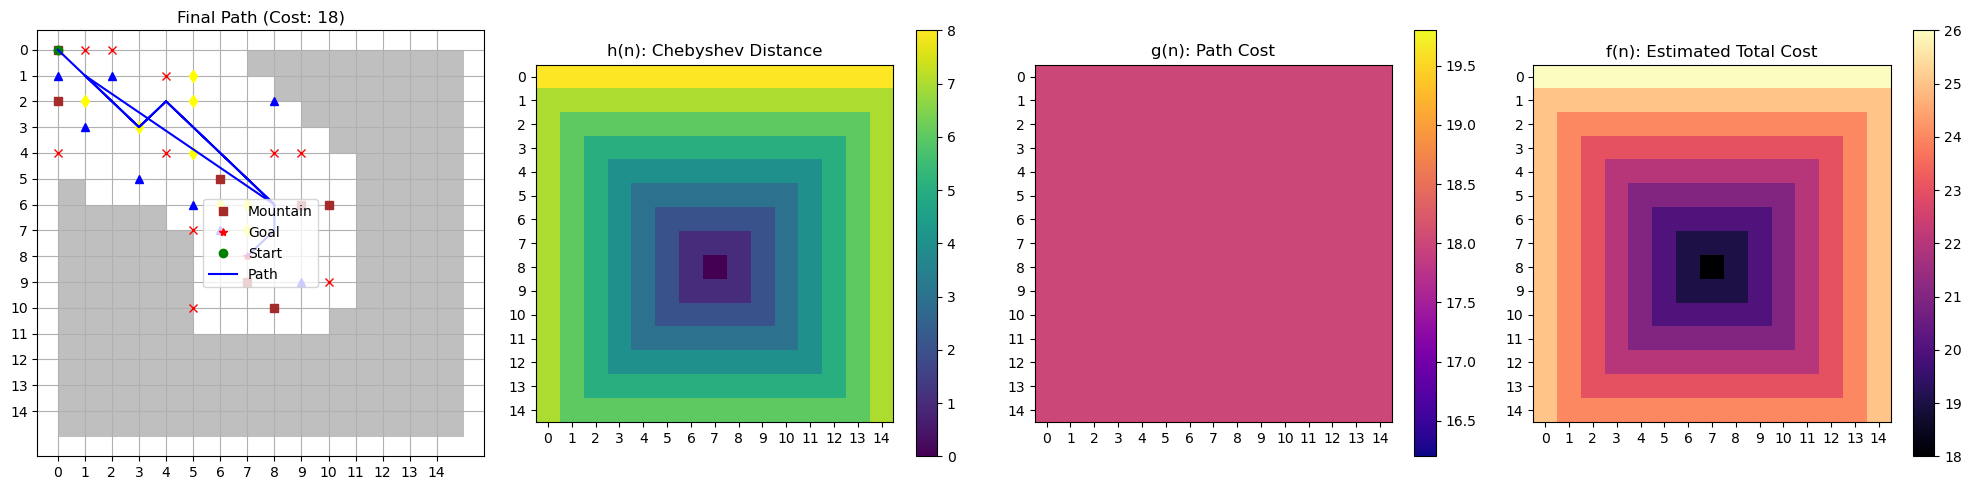

In [1]:
import random
import heapq
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

class Environment:
    def __init__(self, goal_x, goal_y):
        self.grid = [['.' for _ in range(15)] for _ in range(15)]
        self.goal = (goal_x, goal_y)
        self.grid[goal_y][goal_x] = 'G'
        fuel_positions = random.sample([(i,j) for i in range(15) for j in range(15) if (i,j) != (goal_x, goal_y) and (i,j) != (0,0)], 15)
        for pos in fuel_positions:
            self.grid[pos[1]][pos[0]] = 'E'
        num_mountains = int(0.1 * 15 * 15)
        mountain_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_mountains)
        for pos in mountain_positions:
            self.grid[pos[1]][pos[0]] = 'M'
        num_nofly = int(0.1 * 15 * 15)
        nofly_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_nofly)
        for pos in nofly_positions:
            self.grid[pos[1]][pos[0]] = 'N'
        num_storms = int(0.1 * 15 * 15)
        storm_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_storms)
        for pos in storm_positions:
            self.grid[pos[1]][pos[0]] = 'S'

class DroneState:
    def __init__(self, x, y, fuel=100, lives=3, path_cost=0, path=None, known_goal=None, visible_map=None, seen_cells=None):
        self.x = x
        self.y = y
        self.fuel = fuel
        self.lives = lives
        self.path_cost = path_cost
        self.path = path if path is not None else [(x, y)]
        self.known_goal = known_goal
        self.visible_map = visible_map if visible_map is not None else {}
        self.seen_cells = seen_cells if seen_cells is not None else set([(x, y)])
    def __lt__(self, other):
        return False

def get_visible_map(x, y, env):
    visible = {}
    for i in range(max(0, x - 2), min(15, x + 3)):
        for j in range(max(0, y - 2), min(15, y + 3)):
            if max(abs(i - x), abs(j - y)) <= 2:
                visible[(i, j)] = env.grid[j][i]
    return visible

def get_successors(state, env, nodes_expanded):
    moves = [(0,1), (1,0), (0,-1), (-1,0), (1,1), (1,-1), (-1,1), (-1,-1)]
    successors = []
    for dx, dy in moves:
        nx, ny = state.x + dx, state.y + dy
        if 0 <= nx < 15 and 0 <= ny < 15:
            terrain = env.grid[ny][nx]
            if terrain in ['M', 'N']:
                continue
            new_fuel = 10 if terrain == 'E' else state.fuel - 1
            lives_lost = 1 if terrain == 'S' else 0
            if new_fuel < 0:
                lives_lost += 1
            new_lives = state.lives - lives_lost
            if new_lives <= 0:
                continue
            new_path_cost = state.path_cost + 1 + 10 * lives_lost
            new_path = state.path + [(nx, ny)]
            new_visible_map = get_visible_map(nx, ny, env)
            new_known_goal = state.known_goal
            if not new_known_goal and new_visible_map.get(env.goal) == 'G':
                new_known_goal = env.goal
            new_seen_cells = state.seen_cells | set(new_visible_map.keys())
            successors.append(DroneState(nx, ny, new_fuel, new_lives, new_path_cost, new_path, new_known_goal, new_visible_map, new_seen_cells))
    nodes_expanded[0] += len(successors)
    return successors

def h1(state, goal):
    return max(abs(state.x - goal[0]), abs(state.y - goal[1]))

def explore_one_step(state, env, nodes_expanded, visited):
    successors = get_successors(state, env, nodes_expanded)
    if not successors:
        return None
    best_successor = None
    max_new_cells = -1
    min_distance_to_center = float('inf')
    center = (7, 7)
    for successor in successors:
        new_cells = len(successor.seen_cells - state.seen_cells)
        distance_to_center = max(abs(successor.x - center[0]), abs(successor.y - center[1]))
        if (successor.x, successor.y) in visited:
            continue
        if new_cells > max_new_cells or (new_cells == max_new_cells and distance_to_center < min_distance_to_center):
            max_new_cells = new_cells
            min_distance_to_center = distance_to_center
            best_successor = successor
    return best_successor

def a_star_graph(initial_state, goal, heuristic, env, nodes_expanded):
    frontier = [(initial_state.path_cost + heuristic(initial_state, goal), initial_state)]
    explored = set()
    while frontier:
        f_score, current = heapq.heappop(frontier)
        nodes_expanded[0] += 1
        if (current.x, current.y) == goal:
            return current.path, current.path_cost
        state_key = (current.x, current.y)  # Simplified to allow revisiting with different fuel/lives
        if state_key in explored:
            continue
        explored.add(state_key)
        for successor in get_successors(current, env, nodes_expanded):
            if (successor.x, successor.y) not in explored:
                f = successor.path_cost + heuristic(successor, goal)
                heapq.heappush(frontier, (f, successor))
    return None, 0

def plot_grid(state, env, total_path, goal_known, nodes_expanded, log_entry, step):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title(f"Step {step}: Pos ({state.x}, {state.y})\nFuel: {state.fuel}, Lives: {state.lives}, Nodes: {nodes_expanded[0]}")
    plt.grid(True)
    plt.xticks(range(15))
    plt.yticks(range(15))
    for y in range(15):
        for x in range(15):
            if (x, y) not in state.seen_cells:
                plt.fill([x, x+1, x+1, x], [y, y, y+1, y+1], 'gray', alpha=0.5)
            else:
                terrain = env.grid[y][x]
                if terrain == 'M':
                    plt.plot(x, y, 's', color='brown', label='Mountain' if x == 0 and y == 0 else '')
                elif terrain == 'N':
                    plt.plot(x, y, 'x', color='red', label='No-Fly Zone' if x == 0 and y == 0 else '')
                elif terrain == 'S':
                    plt.plot(x, y, '^', color='blue', label='Storm' if x == 0 and y == 0 else '')
                elif terrain == 'E':
                    plt.plot(x, y, 'd', color='yellow', label='Fuel Station' if x == 0 and y == 0 else '')
                elif terrain == 'G' and goal_known:
                    plt.plot(x, y, 'r*', label='Goal' if x == 0 and y == 0 else '')
    plt.plot(0, 0, 'go', label='Start')
    if total_path:
        path_x, path_y = zip(*total_path)
        plt.plot(path_x, path_y, 'b-', label='Path')
    plt.legend()
    plt.gca().invert_yaxis()

    if state.known_goal:
        h_map = np.zeros((15, 15))
        g_map = np.zeros((15, 15))
        f_map = np.zeros((15, 15))
        for x in range(15):
            for y in range(15):
                temp_state = DroneState(x, y, fuel=state.fuel, lives=state.lives, path_cost=state.path_cost)
                h_map[y, x] = h1(temp_state, state.known_goal)
                g_map[y, x] = state.path_cost
                f_map[y, x] = g_map[y, x] + h_map[y, x]

        plt.subplot(1, 4, 2)
        plt.title("h(n): Chebyshev Distance")
        plt.imshow(h_map, cmap='viridis', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 3)
        plt.title("g(n): Path Cost")
        plt.imshow(g_map, cmap='plasma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 4)
        plt.title("f(n): Estimated Total Cost")
        plt.imshow(f_map, cmap='magma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

    plt.tight_layout()
    plt.show()
    clear_output(wait=True)
    print(f"Step Log: {log_entry}")

def run_dynamic_goal_simulation():
    print("Enter goal coordinates (will be hidden until discovered):")
    try:
        goal_x = int(input("Goal x (0-14): "))
        goal_y = int(input("Goal y (0-14): "))
        if not (0 <= goal_x <= 14 and 0 <= goal_y <= 14):
            print("Invalid coordinates")
            return
    except ValueError:
        print("Invalid input")
        return
    env = Environment(goal_x, goal_y)
    initial_visible_map = get_visible_map(0, 0, env)
    initial_state = DroneState(0, 0, visible_map=initial_visible_map)
    current_state = initial_state
    total_path = [(0, 0)]
    total_cost = 0
    nodes_expanded = [0]
    max_steps = 100
    step = 0
    logs = []
    visited = set([(0, 0)])
    a_star_path = None

    while current_state.lives > 0 and current_state.fuel >= 0 and step < max_steps:
        action = "Explore"
        if current_state.known_goal:
            if a_star_path is None:
                action = "Replan to goal"
                logs.append(f"Step {step}: Replanning triggered at ({current_state.x}, {current_state.y})")
                path, path_cost = a_star_graph(current_state, current_state.known_goal, h1, env, nodes_expanded)
                if path:
                    a_star_path = path[1:]  # Skip current position
                    total_cost = path_cost
                    logs.append(f"Step {step}: A* path computed: {path}")
                else:
                    logs.append(f"Step {step}: No path found to goal")
                    break
            if a_star_path:
                next_pos = a_star_path[0]
                a_star_path = a_star_path[1:]
                nx, ny = next_pos
                terrain = env.grid[ny][nx]
                new_fuel = 10 if terrain == 'E' else current_state.fuel - 1
                lives_lost = 1 if terrain == 'S' else 0
                if new_fuel < 0:
                    lives_lost += 1
                new_lives = current_state.lives - lives_lost
                if new_lives <= 0:
                    logs.append(f"Step {step}: Drone died at ({nx}, {ny})")
                    break
                new_path_cost = current_state.path_cost + 1 + 10 * lives_lost
                new_path = current_state.path + [(nx, ny)]
                new_visible_map = get_visible_map(nx, ny, env)
                new_seen_cells = current_state.seen_cells | set(new_visible_map.keys())
                action = f"Move to {next_pos}"
                current_state = DroneState(nx, ny, new_fuel, new_lives, new_path_cost, new_path, current_state.known_goal, new_visible_map, new_seen_cells)
                total_path = new_path
                total_cost = new_path_cost
                step += 1
            else:
                break  # Reached goal or no path
        else:
            next_state = explore_one_step(current_state, env, nodes_expanded, visited)
            if not next_state:
                logs.append(f"Step {step}: No valid moves at ({current_state.x}, {current_state.y})")
                break
            direction = (next_state.x - current_state.x, next_state.y - current_state.y)
            action = f"Move {direction}"
            current_state = next_state
            total_path = current_state.path
            total_cost = current_state.path_cost
            visited.add((current_state.x, current_state.y))
            step += 1

        log_entry = f"Step {step}: Pos=({current_state.x}, {current_state.y}), Action={action}, Fuel={current_state.fuel}, Lives={current_state.lives}"
        logs.append(log_entry)
        plot_grid(current_state, env, total_path, current_state.known_goal is not None, nodes_expanded, log_entry, step)
        time.sleep(0.1)

        if len(current_state.seen_cells) > 0.9 * 15 * 15:
            logs.append(f"Step {step}: Most of grid explored, goal not found")
            break

    success = (current_state.x, current_state.y) == env.goal
    plt.figure(figsize=(10, 8))
    plt.title("MISSION ACCOMPLISHED" if success else "MISSION FAILED")
    plt.text(0.5, 0.5, f"Lives: {current_state.lives}\nFuel: {current_state.fuel}\nNodes Expanded: {nodes_expanded[0]}",
             fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
    plt.axis('off')
    plt.show()
    clear_output(wait=True)

    print("\n=== Mission Log ===")
    for log in logs:
        print(log)
    print(f"\nFinal Status: {'Success' if success else 'Failure'}")
    print(f"Lives: {current_state.lives}, Fuel: {current_state.fuel}, Nodes Expanded: {nodes_expanded[0]}")
    if not success:
        print("\nGrid for Debugging:")
        for row in env.grid:
            print(' '.join(row))

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title(f"Final Path (Cost: {total_cost})")
    plt.grid(True)
    plt.xticks(range(15))
    plt.yticks(range(15))
    for y in range(15):
        for x in range(15):
            if (x, y) not in current_state.seen_cells:
                plt.fill([x, x+1, x+1, x], [y, y, y+1, y+1], 'gray', alpha=0.5)
            else:
                terrain = env.grid[y][x]
                if terrain == 'M':
                    plt.plot(x, y, 's', color='brown', label='Mountain' if x == 0 and y == 0 else '')
                elif terrain == 'N':
                    plt.plot(x, y, 'x', color='red', label='No-Fly Zone' if x == 0 and y == 0 else '')
                elif terrain == 'S':
                    plt.plot(x, y, '^', color='blue', label='Storm' if x == 0 and y == 0 else '')
                elif terrain == 'E':
                    plt.plot(x, y, 'd', color='yellow', label='Fuel Station' if x == 0 and y == 0 else '')
                elif terrain == 'G':
                    plt.plot(x, y, 'r*', label='Goal')
    plt.plot(0, 0, 'go', label='Start')
    if total_path:
        path_x, path_y = zip(*total_path)
        plt.plot(path_x, path_y, 'b-', label='Path')
    plt.legend()
    plt.gca().invert_yaxis()

    if current_state.known_goal:
        h_map = np.zeros((15, 15))
        g_map = np.zeros((15, 15))
        f_map = np.zeros((15, 15))
        for x in range(15):
            for y in range(15):
                temp_state = DroneState(x, y, fuel=current_state.fuel, lives=current_state.lives, path_cost=current_state.path_cost)
                h_map[y, x] = h1(temp_state, current_state.known_goal)
                g_map[y, x] = current_state.path_cost
                f_map[y, x] = g_map[y, x] + h_map[y, x]

        plt.subplot(1, 4, 2)
        plt.title("h(n): Chebyshev Distance")
        plt.imshow(h_map, cmap='viridis', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 3)
        plt.title("g(n): Path Cost")
        plt.imshow(g_map, cmap='plasma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 4)
        plt.title("f(n): Estimated Total Cost")
        plt.imshow(f_map, cmap='magma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_dynamic_goal_simulation()

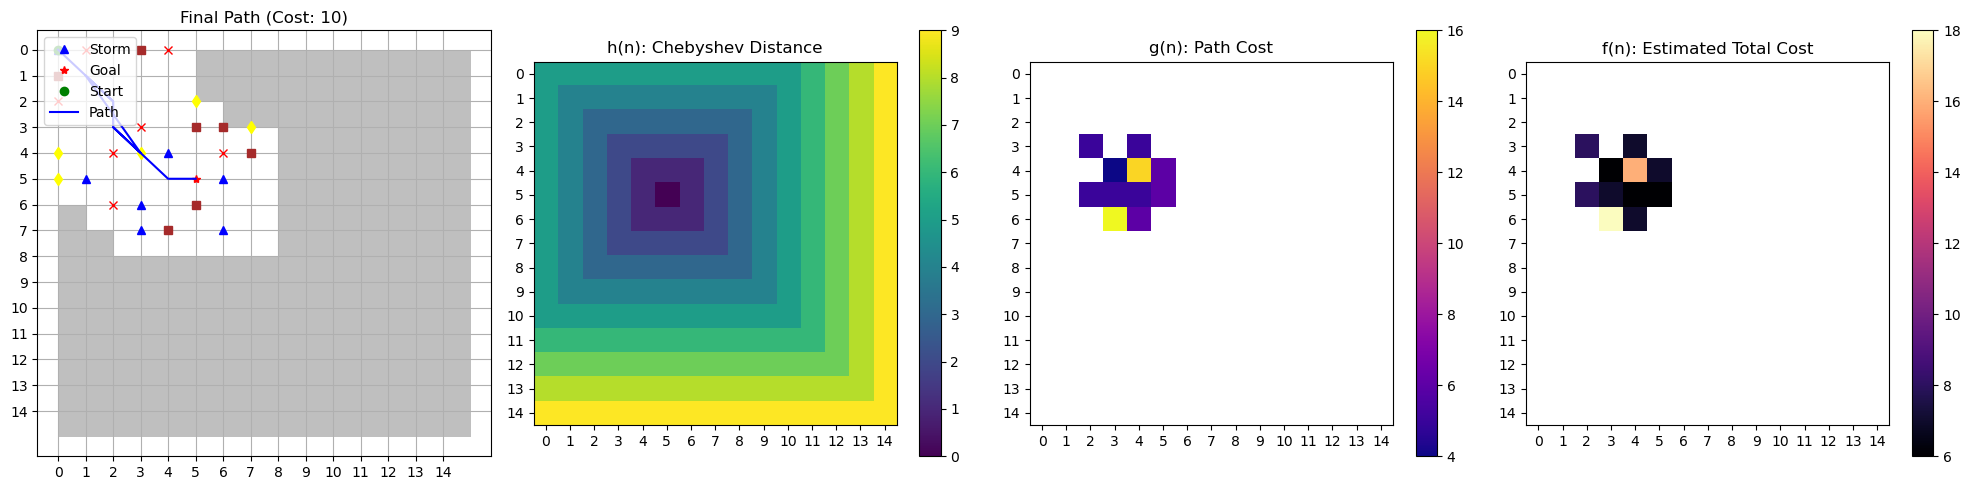

In [4]:
import random
import heapq
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

class Environment:
    def __init__(self, goal_x, goal_y):
        self.grid = [['.' for _ in range(15)] for _ in range(15)]
        self.goal = (goal_x, goal_y)
        self.grid[goal_y][goal_x] = 'G'
        fuel_positions = random.sample([(i,j) for i in range(15) for j in range(15) if (i,j) != (goal_x, goal_y) and (i,j) != (0,0)], 15)
        for pos in fuel_positions:
            self.grid[pos[1]][pos[0]] = 'E'
        num_mountains = int(0.1 * 15 * 15)
        mountain_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_mountains)
        for pos in mountain_positions:
            self.grid[pos[1]][pos[0]] = 'M'
        num_nofly = int(0.1 * 15 * 15)
        nofly_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_nofly)
        for pos in nofly_positions:
            self.grid[pos[1]][pos[0]] = 'N'
        num_storms = int(0.1 * 15 * 15)
        storm_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_storms)
        for pos in storm_positions:
            self.grid[pos[1]][pos[0]] = 'S'

class DroneState:
    def __init__(self, x, y, fuel=100, lives=3, path_cost=0, path=None, known_goal=None, visible_map=None, seen_cells=None):
        self.x = x
        self.y = y
        self.fuel = fuel
        self.lives = lives
        self.path_cost = path_cost
        self.path = path if path is not None else [(x, y)]
        self.known_goal = known_goal
        self.visible_map = visible_map if visible_map is not None else {}
        self.seen_cells = seen_cells if seen_cells is not None else set([(x, y)])
    def __lt__(self, other):
        return False

def get_visible_map(x, y, env):
    visible = {}
    for i in range(max(0, x - 2), min(15, x + 3)):
        for j in range(max(0, y - 2), min(15, y + 3)):
            if max(abs(i - x), abs(j - y)) <= 2:
                visible[(i, j)] = env.grid[j][i]
    return visible

def get_successors(state, env, nodes_expanded):
    moves = [(0,1), (1,0), (0,-1), (-1,0), (1,1), (1,-1), (-1,1), (-1,-1)]
    successors = []
    for dx, dy in moves:
        nx, ny = state.x + dx, state.y + dy
        if 0 <= nx < 15 and 0 <= ny < 15:
            terrain = env.grid[ny][nx]
            if terrain in ['M', 'N']:
                continue
            new_fuel = 10 if terrain == 'E' else state.fuel - 1
            lives_lost = 1 if terrain == 'S' else 0
            if new_fuel < 0:
                lives_lost += 1
            new_lives = state.lives - lives_lost
            if new_lives <= 0:
                continue
            new_path_cost = state.path_cost + 1 + 10 * lives_lost
            new_path = state.path + [(nx, ny)]
            new_visible_map = get_visible_map(nx, ny, env)
            new_known_goal = state.known_goal
            if not new_known_goal and new_visible_map.get(env.goal) == 'G':
                new_known_goal = env.goal
            new_seen_cells = state.seen_cells | set(new_visible_map.keys())
            successors.append(DroneState(nx, ny, new_fuel, new_lives, new_path_cost, new_path, new_known_goal, new_visible_map, new_seen_cells))
    nodes_expanded[0] += len(successors)
    return successors

def h1(state, goal):
    return max(abs(state.x - goal[0]), abs(state.y - goal[1]))

def explore_one_step(state, env, nodes_expanded, visited):
    successors = get_successors(state, env, nodes_expanded)
    if not successors:
        return None
    best_successor = None
    max_new_cells = -1
    min_distance_to_center = float('inf')
    center = (7, 7)
    for successor in successors:
        new_cells = len(successor.seen_cells - state.seen_cells)
        distance_to_center = max(abs(successor.x - center[0]), abs(successor.y - center[1]))
        if (successor.x, successor.y) in visited:
            continue
        if new_cells > max_new_cells or (new_cells == max_new_cells and distance_to_center < min_distance_to_center):
            max_new_cells = new_cells
            min_distance_to_center = distance_to_center
            best_successor = successor
    return best_successor

def a_star_graph(initial_state, goal, heuristic, env, nodes_expanded):
    frontier = [(initial_state.path_cost + heuristic(initial_state, goal), initial_state)]
    explored = set()
    g_costs = {(initial_state.x, initial_state.y): initial_state.path_cost}  # Track g(n) for each cell
    while frontier:
        f_score, current = heapq.heappop(frontier)
        nodes_expanded[0] += 1
        if (current.x, current.y) == goal:
            return current.path, current.path_cost, g_costs
        state_key = (current.x, current.y)
        if state_key in explored:
            continue
        explored.add(state_key)
        for successor in get_successors(current, env, nodes_expanded):
            if (successor.x, successor.y) not in explored:
                new_g = successor.path_cost
                if (successor.x, successor.y) not in g_costs or new_g < g_costs[(successor.x, successor.y)]:
                    g_costs[(successor.x, successor.y)] = new_g
                f = new_g + heuristic(successor, goal)
                heapq.heappush(frontier, (f, successor))
    return None, 0, g_costs

def plot_grid(state, env, total_path, goal_known, nodes_expanded, log_entry, step, g_costs=None):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title(f"Step {step}: Pos ({state.x}, {state.y})\nFuel: {state.fuel}, Lives: {state.lives}, Nodes: {nodes_expanded[0]}")
    plt.grid(True)
    plt.xticks(range(15))
    plt.yticks(range(15))
    for y in range(15):
        for x in range(15):
            if (x, y) not in state.seen_cells:
                plt.fill([x, x+1, x+1, x], [y, y, y+1, y+1], 'gray', alpha=0.5)
            else:
                terrain = env.grid[y][x]
                if terrain == 'M':
                    plt.plot(x, y, 's', color='brown', label='Mountain' if x == 0 and y == 0 else '')
                elif terrain == 'N':
                    plt.plot(x, y, 'x', color='red', label='No-Fly Zone' if x == 0 and y == 0 else '')
                elif terrain == 'S':
                    plt.plot(x, y, '^', color='blue', label='Storm' if x == 0 and y == 0 else '')
                elif terrain == 'E':
                    plt.plot(x, y, 'd', color='yellow', label='Fuel Station' if x == 0 and y == 0 else '')
                elif terrain == 'G' and goal_known:
                    plt.plot(x, y, 'r*', label='Goal' if x == 0 and y == 0 else '')
    plt.plot(0, 0, 'go', label='Start')
    if total_path:
        path_x, path_y = zip(*total_path)
        plt.plot(path_x, path_y, 'b-', label='Path')
    plt.legend()
    plt.gca().invert_yaxis()

    if state.known_goal:
        h_map = np.zeros((15, 15))
        g_map = np.full((15, 15), np.inf)
        f_map = np.zeros((15, 15))
        for x in range(15):
            for y in range(15):
                temp_state = DroneState(x, y, fuel=state.fuel, lives=state.lives, path_cost=state.path_cost)
                h_map[y, x] = h1(temp_state, state.known_goal)
                if (x, y) in g_costs:
                    g_map[y, x] = g_costs[(x, y)]
                f_map[y, x] = g_map[y, x] + h_map[y, x] if g_map[y, x] != np.inf else np.inf

        plt.subplot(1, 4, 2)
        plt.title("h(n): Chebyshev Distance")
        plt.imshow(h_map, cmap='viridis', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 3)
        plt.title("g(n): Path Cost")
        plt.imshow(g_map, cmap='plasma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 4)
        plt.title("f(n): Estimated Total Cost")
        plt.imshow(f_map, cmap='magma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

    plt.tight_layout()
    plt.show()
    clear_output(wait=True)
    print(f"Step Log: {log_entry}")

def run_dynamic_goal_simulation():
    print("Enter goal coordinates (will be hidden until discovered):")
    try:
        goal_x = int(input("Goal x (0-14): "))
        goal_y = int(input("Goal y (0-14): "))
        if not (0 <= goal_x <= 14 and 0 <= goal_y <= 14):
            print("Invalid coordinates")
            return
    except ValueError:
        print("Invalid input")
        return
    env = Environment(goal_x, goal_y)
    initial_visible_map = get_visible_map(0, 0, env)
    initial_state = DroneState(0, 0, visible_map=initial_visible_map)
    current_state = initial_state
    total_path = [(0, 0)]
    total_cost = 0
    nodes_expanded = [0]
    max_steps = 100
    step = 0
    logs = []
    visited = set([(0, 0)])
    a_star_path = None
    g_costs = {}  # Track g(n) for heatmap

    while current_state.lives > 0 and current_state.fuel >= 0 and step < max_steps:
        action = "Explore"
        if current_state.known_goal:
            if a_star_path is None:
                action = "Replan to goal"
                logs.append(f"Step {step}: Replanning triggered at ({current_state.x}, {current_state.y})")
                path, path_cost, g_costs = a_star_graph(current_state, current_state.known_goal, h1, env, nodes_expanded)
                if path:
                    a_star_path = path[1:]  # Skip current position
                    total_cost = path_cost
                    logs.append(f"Step {step}: A* path computed: {path}")
                else:
                    logs.append(f"Step {step}: No path found to goal")
                    break
            if a_star_path:
                next_pos = a_star_path[0]
                a_star_path = a_star_path[1:]
                nx, ny = next_pos
                terrain = env.grid[ny][nx]
                new_fuel = 10 if terrain == 'E' else current_state.fuel - 1
                lives_lost = 1 if terrain == 'S' else 0
                if new_fuel < 0:
                    lives_lost += 1
                new_lives = current_state.lives - lives_lost
                if new_lives <= 0:
                    logs.append(f"Step {step}: Drone died at ({nx}, {ny})")
                    break
                new_path_cost = current_state.path_cost + 1 + 10 * lives_lost
                new_path = current_state.path + [(nx, ny)]
                new_visible_map = get_visible_map(nx, ny, env)
                new_seen_cells = current_state.seen_cells | set(new_visible_map.keys())
                action = f"Move to {next_pos}"
                current_state = DroneState(nx, ny, new_fuel, new_lives, new_path_cost, new_path, current_state.known_goal, new_visible_map, new_seen_cells)
                total_path = new_path
                total_cost = new_path_cost
                step += 1
            else:
                break  # Reached goal or no path
        else:
            next_state = explore_one_step(current_state, env, nodes_expanded, visited)
            if not next_state:
                logs.append(f"Step {step}: No valid moves at ({current_state.x}, {current_state.y})")
                break
            direction = (next_state.x - current_state.x, next_state.y - current_state.y)
            action = f"Move {direction}"
            current_state = next_state
            total_path = current_state.path
            total_cost = current_state.path_cost
            visited.add((current_state.x, current_state.y))
            step += 1

        log_entry = f"Step {step}: Pos=({current_state.x}, {current_state.y}), Action={action}, Fuel={current_state.fuel}, Lives={current_state.lives}"
        logs.append(log_entry)
        plot_grid(current_state, env, total_path, current_state.known_goal is not None, nodes_expanded, log_entry, step, g_costs)
        time.sleep(0.1)

        if len(current_state.seen_cells) > 0.9 * 15 * 15:
            logs.append(f"Step {step}: Most of grid explored, goal not found")
            break

    success = (current_state.x, current_state.y) == env.goal
    plt.figure(figsize=(10, 8))
    plt.title("MISSION ACCOMPLISHED" if success else "MISSION FAILED")
    plt.text(0.5, 0.5, f"Lives: {current_state.lives}\nFuel: {current_state.fuel}\nNodes Expanded: {nodes_expanded[0]}",
             fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
    plt.axis('off')
    plt.show()
    clear_output(wait=True)

    print("\n=== Mission Log ===")
    for log in logs:
        print(log)
    print(f"\nFinal Status: {'Success' if success else 'Failure'}")
    print(f"Lives: {current_state.lives}, Fuel: {current_state.fuel}, Nodes Expanded: {nodes_expanded[0]}")
    if not success:
        print("\nGrid for Debugging:")
        for row in env.grid:
            print(' '.join(row))

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title(f"Final Path (Cost: {total_cost})")
    plt.grid(True)
    plt.xticks(range(15))
    plt.yticks(range(15))
    for y in range(15):
        for x in range(15):
            if (x, y) not in current_state.seen_cells:
                plt.fill([x, x+1, x+1, x], [y, y, y+1, y+1], 'gray', alpha=0.5)
            else:
                terrain = env.grid[y][x]
                if terrain == 'M':
                    plt.plot(x, y, 's', color='brown', label='Mountain' if x == 0 and y == 0 else '')
                elif terrain == 'N':
                    plt.plot(x, y, 'x', color='red', label='No-Fly Zone' if x == 0 and y == 0 else '')
                elif terrain == 'S':
                    plt.plot(x, y, '^', color='blue', label='Storm' if x == 0 and y == 0 else '')
                elif terrain == 'E':
                    plt.plot(x, y, 'd', color='yellow', label='Fuel Station' if x == 0 and y == 0 else '')
                elif terrain == 'G':
                    plt.plot(x, y, 'r*', label='Goal')
    plt.plot(0, 0, 'go', label='Start')
    if total_path:
        path_x, path_y = zip(*total_path)
        plt.plot(path_x, path_y, 'b-', label='Path')
    plt.legend()
    plt.gca().invert_yaxis()

    if current_state.known_goal:
        h_map = np.zeros((15, 15))
        g_map = np.full((15, 15), np.inf)
        f_map = np.zeros((15, 15))
        for x in range(15):
            for y in range(15):
                temp_state = DroneState(x, y, fuel=current_state.fuel, lives=current_state.lives, path_cost=current_state.path_cost)
                h_map[y, x] = h1(temp_state, current_state.known_goal)
                if (x, y) in g_costs:
                    g_map[y, x] = g_costs[(x, y)]
                f_map[y, x] = g_map[y, x] + h_map[y, x] if g_map[y, x] != np.inf else np.inf

        plt.subplot(1, 4, 2)
        plt.title("h(n): Chebyshev Distance")
        plt.imshow(h_map, cmap='viridis', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 3)
        plt.title("g(n): Path Cost")
        plt.imshow(g_map, cmap='plasma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 4)
        plt.title("f(n): Estimated Total Cost")
        plt.imshow(f_map, cmap='magma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_dynamic_goal_simulation()

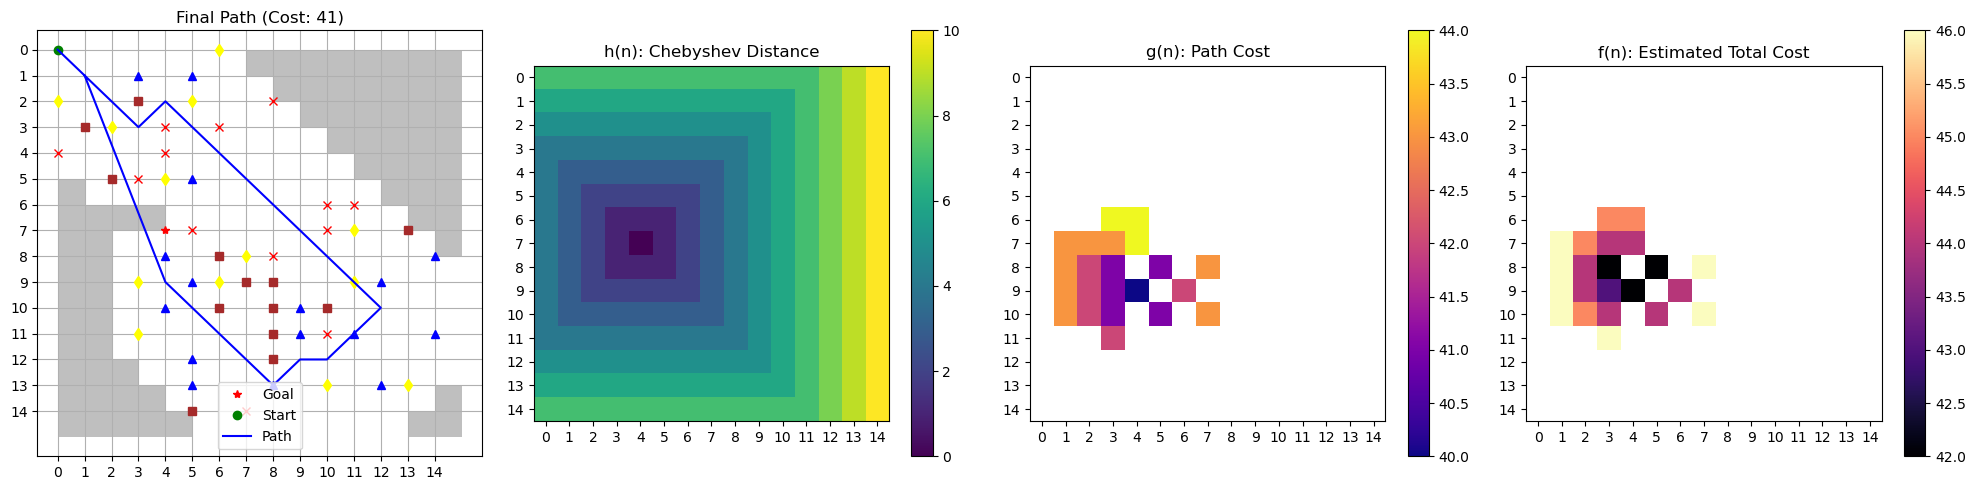

In [5]:
import random
import heapq
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

class Environment:
    def __init__(self, goal_x, goal_y):
        self.grid = [['.' for _ in range(15)] for _ in range(15)]
        self.goal = (goal_x, goal_y)
        self.grid[goal_y][goal_x] = 'G'
        fuel_positions = random.sample([(i,j) for i in range(15) for j in range(15) if (i,j) != (goal_x, goal_y) and (i,j) != (0,0)], 15)
        for pos in fuel_positions:
            self.grid[pos[1]][pos[0]] = 'E'
        num_mountains = int(0.1 * 15 * 15)
        mountain_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_mountains)
        for pos in mountain_positions:
            self.grid[pos[1]][pos[0]] = 'M'
        num_nofly = int(0.1 * 15 * 15)
        nofly_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_nofly)
        for pos in nofly_positions:
            self.grid[pos[1]][pos[0]] = 'N'
        num_storms = int(0.1 * 15 * 15)
        storm_positions = random.sample([(i,j) for i in range(15) for j in range(15) if self.grid[j][i] == '.'], num_storms)
        for pos in storm_positions:
            self.grid[pos[1]][pos[0]] = 'S'

class DroneState:
    def __init__(self, x, y, fuel=100, lives=3, path_cost=0, path=None, known_goal=None, visible_map=None, seen_cells=None):
        self.x = x
        self.y = y
        self.fuel = fuel
        self.lives = lives
        self.path_cost = path_cost
        self.path = path if path is not None else [(x, y)]
        self.known_goal = known_goal
        self.visible_map = visible_map if visible_map is not None else {}
        self.seen_cells = seen_cells if seen_cells is not None else set([(x, y)])
    def __lt__(self, other):
        return False

def get_visible_map(x, y, env):
    visible = {}
    for i in range(max(0, x - 2), min(15, x + 3)):
        for j in range(max(0, y - 2), min(15, y + 3)):
            if max(abs(i - x), abs(j - y)) <= 2:
                visible[(i, j)] = env.grid[j][i]
    return visible

def get_successors(state, env, nodes_expanded):
    moves = [(0,1), (1,0), (0,-1), (-1,0), (1,1), (1,-1), (-1,1), (-1,-1)]
    successors = []
    for dx, dy in moves:
        nx, ny = state.x + dx, state.y + dy
        if 0 <= nx < 15 and 0 <= ny < 15:
            terrain = env.grid[ny][nx]
            if terrain in ['M', 'N']:
                continue
            new_fuel = 10 if terrain == 'E' else state.fuel - 1
            lives_lost = 1 if terrain == 'S' else 0
            if new_fuel < 0:
                lives_lost += 1
            new_lives = state.lives - lives_lost
            if new_lives <= 0:
                continue
            new_path_cost = state.path_cost + 1 + 10 * lives_lost
            new_path = state.path + [(nx, ny)]
            new_visible_map = get_visible_map(nx, ny, env)
            new_known_goal = state.known_goal
            if not new_known_goal and new_visible_map.get(env.goal) == 'G':
                new_known_goal = env.goal
            new_seen_cells = state.seen_cells | set(new_visible_map.keys())
            successors.append(DroneState(nx, ny, new_fuel, new_lives, new_path_cost, new_path, new_known_goal, new_visible_map, new_seen_cells))
    nodes_expanded[0] += len(successors)
    return successors

def h1(state, goal):
    return max(abs(state.x - goal[0]), abs(state.y - goal[1]))

def explore_one_step(state, env, nodes_expanded, visited):
    successors = get_successors(state, env, nodes_expanded)
    if not successors:
        return None
    best_successor = None
    max_new_cells = -1
    min_distance_to_center = float('inf')
    center = (7, 7)
    for successor in successors:
        new_cells = len(successor.seen_cells - state.seen_cells)
        distance_to_center = max(abs(successor.x - center[0]), abs(successor.y - center[1]))
        if (successor.x, successor.y) in visited:
            continue
        if new_cells > max_new_cells or (new_cells == max_new_cells and distance_to_center < min_distance_to_center):
            max_new_cells = new_cells
            min_distance_to_center = distance_to_center
            best_successor = successor
    return best_successor

def a_star_graph(initial_state, goal, heuristic, env, nodes_expanded):
    frontier = [(initial_state.path_cost + heuristic(initial_state, goal), initial_state)]
    explored = set()
    g_costs = {(initial_state.x, initial_state.y): initial_state.path_cost}  # Track g(n) for each cell
    while frontier:
        f_score, current = heapq.heappop(frontier)
        nodes_expanded[0] += 1
        if (current.x, current.y) == goal:
            return current.path, current.path_cost, g_costs
        state_key = (current.x, current.y)
        if state_key in explored:
            continue
        explored.add(state_key)
        for successor in get_successors(current, env, nodes_expanded):
            if (successor.x, successor.y) not in explored:
                new_g = successor.path_cost
                if (successor.x, successor.y) not in g_costs or new_g < g_costs[(successor.x, successor.y)]:
                    g_costs[(successor.x, successor.y)] = new_g
                f = new_g + heuristic(successor, goal)
                heapq.heappush(frontier, (f, successor))
    return None, 0, g_costs

def plot_grid(state, env, total_path, goal_known, nodes_expanded, log_entry, step, g_costs=None):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title(f"Step {step}: Pos ({state.x}, {state.y})\nFuel: {state.fuel}, Lives: {state.lives}, Nodes: {nodes_expanded[0]}")
    plt.grid(True)
    plt.xticks(range(15))
    plt.yticks(range(15))
    for y in range(15):
        for x in range(15):
            if (x, y) not in state.seen_cells:
                plt.fill([x, x+1, x+1, x], [y, y, y+1, y+1], 'gray', alpha=0.5)
            else:
                terrain = env.grid[y][x]
                if terrain == 'M':
                    plt.plot(x, y, 's', color='brown', label='Mountain' if x == 0 and y == 0 else '')
                elif terrain == 'N':
                    plt.plot(x, y, 'x', color='red', label='No-Fly Zone' if x == 0 and y == 0 else '')
                elif terrain == 'S':
                    plt.plot(x, y, '^', color='blue', label='Storm' if x == 0 and y == 0 else '')
                elif terrain == 'E':
                    plt.plot(x, y, 'd', color='yellow', label='Fuel Station' if x == 0 and y == 0 else '')
                elif terrain == 'G' and goal_known:
                    plt.plot(x, y, 'r*', label='Goal' if x == 0 and y == 0 else '')
    plt.plot(0, 0, 'go', label='Start')
    if total_path:
        path_x, path_y = zip(*total_path)
        plt.plot(path_x, path_y, 'b-', label='Path')
    plt.legend()
    plt.gca().invert_yaxis()

    if state.known_goal:
        h_map = np.zeros((15, 15))
        g_map = np.full((15, 15), np.inf)
        f_map = np.zeros((15, 15))
        for x in range(15):
            for y in range(15):
                temp_state = DroneState(x, y, fuel=state.fuel, lives=state.lives, path_cost=state.path_cost)
                h_map[y, x] = h1(temp_state, state.known_goal)
                if (x, y) in g_costs:
                    g_map[y, x] = g_costs[(x, y)]
                f_map[y, x] = g_map[y, x] + h_map[y, x] if g_map[y, x] != np.inf else np.inf

        plt.subplot(1, 4, 2)
        plt.title("h(n): Chebyshev Distance")
        plt.imshow(h_map, cmap='viridis', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 3)
        plt.title("g(n): Path Cost")
        plt.imshow(g_map, cmap='plasma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 4)
        plt.title("f(n): Estimated Total Cost")
        plt.imshow(f_map, cmap='magma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

    plt.tight_layout()
    plt.show()
    clear_output(wait=True)
    print(f"Step Log: {log_entry}")

def run_dynamic_goal_simulation():
    print("Enter goal coordinates (will be hidden until discovered):")
    try:
        goal_x = int(input("Goal x (0-14): "))
        goal_y = int(input("Goal y (0-14): "))
        if not (0 <= goal_x <= 14 and 0 <= goal_y <= 14):
            print("Invalid coordinates")
            return
    except ValueError:
        print("Invalid input")
        return
    env = Environment(goal_x, goal_y)
    initial_visible_map = get_visible_map(0, 0, env)
    initial_state = DroneState(0, 0, visible_map=initial_visible_map)
    current_state = initial_state
    total_path = [(0, 0)]
    total_cost = 0
    nodes_expanded = [0]
    max_steps = 100
    step = 0
    logs = []
    visited = set([(0, 0)])
    a_star_path = None
    g_costs = {}  # Track g(n) for heatmap

    while current_state.lives > 0 and current_state.fuel >= 0 and step < max_steps:
        action = "Explore"
        if current_state.known_goal:
            if a_star_path is None:
                action = "Replan to goal"
                logs.append(f"Step {step}: Replanning triggered at ({current_state.x}, {current_state.y})")
                path, path_cost, g_costs = a_star_graph(current_state, current_state.known_goal, h1, env, nodes_expanded)
                if path:
                    a_star_path = path[1:]  # Skip current position
                    total_cost = path_cost
                    logs.append(f"Step {step}: A* path computed: {path}")
                else:
                    logs.append(f"Step {step}: No path found to goal")
                    break
            if a_star_path:
                next_pos = a_star_path[0]
                a_star_path = a_star_path[1:]
                nx, ny = next_pos
                terrain = env.grid[ny][nx]
                new_fuel = 10 if terrain == 'E' else current_state.fuel - 1
                lives_lost = 1 if terrain == 'S' else 0
                if new_fuel < 0:
                    lives_lost += 1
                new_lives = current_state.lives - lives_lost
                if new_lives <= 0:
                    logs.append(f"Step {step}: Drone died at ({nx}, {ny})")
                    break
                new_path_cost = current_state.path_cost + 1 + 10 * lives_lost
                new_path = current_state.path + [(nx, ny)]
                new_visible_map = get_visible_map(nx, ny, env)
                new_seen_cells = current_state.seen_cells | set(new_visible_map.keys())
                action = f"Move to {next_pos}"
                current_state = DroneState(nx, ny, new_fuel, new_lives, new_path_cost, new_path, current_state.known_goal, new_visible_map, new_seen_cells)
                total_path = new_path
                total_cost = new_path_cost
                step += 1
            else:
                break  # Reached goal or no path
        else:
            next_state = explore_one_step(current_state, env, nodes_expanded, visited)
            if not next_state:
                logs.append(f"Step {step}: No valid moves at ({current_state.x}, {current_state.y})")
                break
            direction = (next_state.x - current_state.x, next_state.y - current_state.y)
            action = f"Move {direction}"
            current_state = next_state
            total_path = current_state.path
            total_cost = current_state.path_cost
            visited.add((current_state.x, current_state.y))
            step += 1

        log_entry = f"Step {step}: Pos=({current_state.x}, {current_state.y}), Action={action}, Fuel={current_state.fuel}, Lives={current_state.lives}"
        logs.append(log_entry)
        plot_grid(current_state, env, total_path, current_state.known_goal is not None, nodes_expanded, log_entry, step, g_costs)
        time.sleep(0.1)

        if len(current_state.seen_cells) > 0.9 * 15 * 15:
            logs.append(f"Step {step}: Most of grid explored, goal not found")
            break

    success = (current_state.x, current_state.y) == env.goal
    plt.figure(figsize=(10, 8))
    plt.title("MISSION ACCOMPLISHED" if success else "MISSION FAILED")
    plt.text(0.5, 0.5, f"Lives: {current_state.lives}\nFuel: {current_state.fuel}\nNodes Expanded: {nodes_expanded[0]}",
             fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
    plt.axis('off')
    plt.show()
    clear_output(wait=True)

    print("\n=== Mission Log ===")
    for log in logs:
        print(log)
    print(f"\nFinal Status: {'Success' if success else 'Failure'}")
    print(f"Lives: {current_state.lives}, Fuel: {current_state.fuel}, Nodes Expanded: {nodes_expanded[0]}")
    if not success:
        print("\nGrid for Debugging:")
        for row in env.grid:
            print(' '.join(row))

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title(f"Final Path (Cost: {total_cost})")
    plt.grid(True)
    plt.xticks(range(15))
    plt.yticks(range(15))
    for y in range(15):
        for x in range(15):
            if (x, y) not in current_state.seen_cells:
                plt.fill([x, x+1, x+1, x], [y, y, y+1, y+1], 'gray', alpha=0.5)
            else:
                terrain = env.grid[y][x]
                if terrain == 'M':
                    plt.plot(x, y, 's', color='brown', label='Mountain' if x == 0 and y == 0 else '')
                elif terrain == 'N':
                    plt.plot(x, y, 'x', color='red', label='No-Fly Zone' if x == 0 and y == 0 else '')
                elif terrain == 'S':
                    plt.plot(x, y, '^', color='blue', label='Storm' if x == 0 and y == 0 else '')
                elif terrain == 'E':
                    plt.plot(x, y, 'd', color='yellow', label='Fuel Station' if x == 0 and y == 0 else '')
                elif terrain == 'G':
                    plt.plot(x, y, 'r*', label='Goal')
    plt.plot(0, 0, 'go', label='Start')
    if total_path:
        path_x, path_y = zip(*total_path)
        plt.plot(path_x, path_y, 'b-', label='Path')
    plt.legend()
    plt.gca().invert_yaxis()

    if current_state.known_goal:
        h_map = np.zeros((15, 15))
        g_map = np.full((15, 15), np.inf)
        f_map = np.zeros((15, 15))
        for x in range(15):
            for y in range(15):
                temp_state = DroneState(x, y, fuel=current_state.fuel, lives=current_state.lives, path_cost=current_state.path_cost)
                h_map[y, x] = h1(temp_state, current_state.known_goal)
                if (x, y) in g_costs:
                    g_map[y, x] = g_costs[(x, y)]
                f_map[y, x] = g_map[y, x] + h_map[y, x] if g_map[y, x] != np.inf else np.inf

        plt.subplot(1, 4, 2)
        plt.title("h(n): Chebyshev Distance")
        plt.imshow(h_map, cmap='viridis', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 3)
        plt.title("g(n): Path Cost")
        plt.imshow(g_map, cmap='plasma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

        plt.subplot(1, 4, 4)
        plt.title("f(n): Estimated Total Cost")
        plt.imshow(f_map, cmap='magma', origin='upper')
        plt.colorbar()
        plt.xticks(range(15))
        plt.yticks(range(15))

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_dynamic_goal_simulation()

## Full Integration: User Input + Terrain Reshuffling + Full Visuals

In [1]:
def run_full_drone_visualization_with_input_and_reshuffling():
    try:
        gx = int(input("Enter goal X coordinate (0–14): "))
        gy = int(input("Enter goal Y coordinate (0–14): "))
        if not (0 <= gx < 15 and 0 <= gy < 15):
            print("Invalid goal coordinates.")
            return
    except ValueError:
        print("Invalid input.")
        return

    goal_pos = (gx, gy)
    print(f"\n🎯 Goal set at: {goal_pos}")

    terrain, _, _ = generate_random_terrain(goal_override=goal_pos)
    start_state = init_start_state()
    logger = DroneLogger()

    open_list = []
    heapq.heappush(open_list, (0, start_state))
    came_from = {}
    visited = set()
    expanded = 0
    g_values = {}
    h_values = {}
    f_values = {}
    step_count = 0

    while open_list:
        _, current = heapq.heappop(open_list)
        key = (current.x, current.y, current.lives, current.fuel)

        if key in visited:
            continue
        visited.add(key)
        expanded += 1
        pos = current.position()
        g_values[pos] = current.path_cost

        logger.log_step(current.time_step, pos, action="move", fuel=current.fuel, lives=current.lives)

        if pos == goal_pos:
            path = reconstruct_path(came_from, current)
            logger.set_total_expanded(expanded)

            animate_drone_path(path, terrain, goal_pos, logger, delay=0.4)
            logger.print_summary()
            plot_heuristic_maps(f_values, g_values, h_values)
            return

        # Reshuffle terrain every 10 steps
        if current.time_step > 0 and current.time_step % 10 == 0:
            terrain, _, _ = generate_random_terrain(goal_override=goal_pos)
            logger.log_replan(current.time_step)
            visited = set()  # allow replanning to revisit

        for child in get_successors(current, terrain):
            child_key = (child.x, child.y, child.lives, child.fuel)
            if child_key in visited:
                continue

            # Compute heuristic
            if heuristic_h5 == heuristic_h2:
                h = heuristic_h2(child.position(), goal_pos, child.fuel)
            elif heuristic_h5 == heuristic_h3:
                h = heuristic_h3(child.position(), goal_pos, child.lives, child.known_storm_map)
            else:
                h = heuristic_h5(child.position(), goal_pos, child.fuel, child.lives,
                                 child.known_storm_map, child.known_no_fly_zones, child.time_step)

            g = child.path_cost
            f = g + h

            g_values[child.position()] = g
            h_values[child.position()] = h
            f_values[child.position()] = f

            heapq.heappush(open_list, (f, child))
            came_from[child] = current

    print("❌ MISSION FAILED: No path found.")
